## **Model Training**

Import required packages and libraries 

In [247]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('ggplot')
# Set the Pandas display options to show all columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import statsmodels.api as sm
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy import stats 
# import scikit-learn packages 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, make_scorer, silhouette_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, IsolationForest
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE,RFECV, SelectKBest, f_regression
from sklearn.cluster import KMeans
import shap
import warnings
warnings.filterwarnings('ignore')
import joblib

### Read data 

In [2]:
 #Read data from Excel files into Pandas DataFrames
credit_consumption = pd.read_excel('data/CreditConsumptionData.xlsx')
customer_behaviour = pd.read_excel('data/CustomerBehaviorData.xlsx') 
customer_demographics = pd.read_excel('data/CustomerDemographics.xlsx')

In [3]:
# merge data frames on 'ID' variable and name it customer_credit
customer_data = pd.merge(customer_behaviour, customer_demographics, on = 'ID', how='inner')
customer_credit = pd.merge(customer_data, credit_consumption, on='ID', how='inner')

# save data
customer_credit.to_csv('customer_credit_merge_original.csv', index=False)
customer_credit.head()

,ID,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons
0,17051,3412.60,2909.34,1077.36,3084.50,4615.97,6693.0,19.0,10,2,53,1,42,358000,1,1,1.0,1,331.2,130000.00,300500.0,12174.0,25210.23,27532.37,103.0,36,28579.0,44974.63,42852.00,1,108,97916.0,45253.64,47635.00,2,18,19947.0,Y,3448.84,current,M,30,MEDIUM,7.0,5,956.0,1,20.0,13434.0
1,11491,18133.76,3877.00,6123.78,5597.43,64620.00,6117.0,4.0,60,1,4,1,17,114000,1,1,1.0,1,5809950.0,3.00,610000.0,2351.0,30937.00,50784.00,40.0,35,25379.0,117575.67,24257.00,1,4,25125.0,12912.33,18369.00,3,49,20585.0,Y,3812.69,current,M,37,LOW,10.2,8,966.0,1,5.0,449.0
2,7433,6363.65,735.49,8799.00,13768.00,38266.00,2638.0,2.0,83,47,4,62,42,360000,1,1,1.0,1,27324.0,176487.60,2156.0,3735.0,12940.25,26345.00,11.0,3,19224.0,14646.35,38306.00,70,11,38546.0,93567.51,26713.00,47,49,13950.0,Y,9432.90,current,M,33,MEDIUM,3.9,3,505.0,1,15.0,11968.0
3,14606,12765.66,4429.16,16745.86,6360.00,29063.97,3711.0,12.0,2,16,24,12,58,155000,1,1,1.0,1,370776.0,63000.00,26241.0,0.0,78122.15,49660.00,42.0,26,72186.0,14719.00,46132.05,43,1,180315.0,176394.48,35062.74,3,37,37018.0,Y,144.61,current,M,63,LOW,25.8,6,631.0,0,15.0,32029.0
4,8381,27819.70,1944.00,7006.50,2228.50,1096.25,1065.0,15.0,13,61,7,5,80,362000,1,1,1.0,1,10006.2,7216.53,13873.0,-4679.0,6855.71,933699.00,46.0,35,18867.0,189938.76,37191.00,2,14,13480.0,3167.00,19056.00,2,15,24274.0,Y,1887.89,saving,M,33,MEDIUM,6.5,7,698.0,0,9.0,16394.0


In [4]:
# for consistent naming convert  all letter in feature names to lower case
customer_credit.columns = customer_credit.columns.str.lower()

In [5]:
# information about dataset
customer_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            20000 non-null  int64  
 1   cc_cons_apr                   20000 non-null  float64
 2   dc_cons_apr                   20000 non-null  float64
 3   cc_cons_may                   19999 non-null  float64
 4   dc_cons_may                   20000 non-null  float64
 5   cc_cons_jun                   20000 non-null  float64
 6   dc_cons_jun                   19999 non-null  float64
 7   cc_count_apr                  19999 non-null  float64
 8   cc_count_may                  20000 non-null  int64  
 9   cc_count_jun                  20000 non-null  int64  
 10  dc_count_apr                  20000 non-null  int64  
 11  dc_count_may                  20000 non-null  int64  
 12  dc_count_jun                  20000 non-null  int64  
 13  c

In [6]:
# drop duplicates if any 
customer_credit.drop_duplicates(inplace=True)

In [7]:
# remove rows with missing target 'cc_cons'
customer_credit.dropna(subset=['cc_cons'], inplace=True)

In [8]:
# drop 'id' column
customer_credit.drop('id', axis=1, inplace=True)

In [9]:
# check missing values in the data 
customer_credit.isnull().sum()

cc_cons_apr                     0
dc_cons_apr                     0
cc_cons_may                     0
dc_cons_may                     0
cc_cons_jun                     0
dc_cons_jun                     0
cc_count_apr                    1
cc_count_may                    0
cc_count_jun                    0
dc_count_apr                    0
dc_count_may                    0
dc_count_jun                    0
card_lim                        0
personal_loan_active            0
vehicle_loan_active             0
personal_loan_closed            1
vehicle_loan_closed             0
investment_1                    0
investment_2                    0
investment_3                    2
investment_4                    0
debit_amount_apr                0
credit_amount_apr               0
debit_count_apr                 1
credit_count_apr                0
max_credit_amount_apr           0
debit_amount_may                0
credit_amount_may               0
credit_count_may                0
debit_count_ma

In [10]:
# since we have only few rows with missing values we will drop them 
customer_credit.dropna(inplace=True)

In [11]:
# descriptive statistics train data
customer_credit.describe(percentiles=(0.25, 0.5, 0.75, 0.95, 0.99)).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
cc_cons_apr,14995.0,17960.830861,2.519132e+04,253.00,4411.590,10288.10,21407.625,60198.734,1.238253e+05,441031.33
dc_cons_apr,14995.0,8171.498747,1.477513e+04,19.35,1634.000,3994.80,9339.020,27835.000,6.480400e+04,229255.00
cc_cons_may,14995.0,16338.688883,2.706498e+04,157.00,3638.000,8694.00,18951.300,54959.784,1.264722e+05,1117246.31
dc_cons_may,14995.0,7702.797188,1.898898e+04,22.00,1643.500,3821.00,8212.000,25430.894,6.479424e+04,911223.49
cc_cons_jun,14995.0,12130.345532,1.849140e+04,65.00,3004.500,6655.25,14247.000,40127.367,8.696523e+04,382914.10
dc_cons_jun,14995.0,7098.205684,1.325377e+04,62.00,1358.000,3327.00,7597.000,24148.830,7.163800e+04,233384.00
cc_count_apr,14995.0,41.492631,9.744751e+01,1.00,5.000,10.00,44.000,124.000,5.310000e+02,531.00
cc_count_may,14995.0,33.488296,4.954749e+01,1.00,8.000,23.00,43.000,93.000,1.280000e+02,601.00
cc_count_jun,14995.0,41.496699,4.734729e+01,1.00,10.000,35.00,61.000,89.000,1.350000e+02,653.00
dc_count_apr,14995.0,17.167256,1.935888e+01,1.00,2.000,7.00,25.000,54.000,6.200000e+01,82.00


we can remove the features which have standard deviation of 0 becuase they have constant values. 

In [12]:
# list the columns to drop
columns_to_drop = ['personal_loan_active', 'vehicle_loan_active',	'personal_loan_closed', 'vehicle_loan_closed']
# drop the columns 
customer_credit.drop(columns=columns_to_drop, axis=1, inplace=True)

## **Feature Engineering**

### Categorical encoding 

In [13]:
customer_credit.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
loan_enq,14995,1,Y,14995
account_type,14995,2,current,12722
gender,14995,2,M,12941
income,14995,3,MEDIUM,9610


In [14]:
# since we have single class in 'loan_enq' we can drop.
customer_credit.drop('loan_enq', axis=1, inplace=True)


- `income` is ordinal categorical variable we perform ordinal encoding
- `gender` and `account_type` type are nominal variables we perform one-hot encoding.  

In [15]:
# ordiinal mapping
ordinal_mapping = {'HIGH': 2, 'MEDIUM': 1, 'LOW':0}
# label encoding the ordinal variable
customer_credit['income'] = customer_credit['income'].map(ordinal_mapping)
# one-hot encoding nominal categorical variables : gender and account_type
customer_credit = pd.get_dummies(customer_credit, columns=['gender', 'account_type'], drop_first=True) 

________________

## **Outlier Treatment**

#### Identifying Outliers in Feature Data
We are analyzing a specific feature to detect outliers. To achieve this, we focus on the 95th to 100th percentile values within the feature. These percentiles represent the top 5% of data points. By doing so, we aim to identify extreme values that deviate significantly from the majority of the data. Identifying outliers is crucial for data quality assurance and informs subsequent data analysis.

In [16]:
# seperate numerical features for outlier treatment
categorical_columns = ['income', 'gender_M', 'account_type_saving','netbanking_flag', 'region_code']
numerical_columns = customer_credit.drop(categorical_columns, axis=1).columns.tolist()

Visualise distribution to check for features with outliers 

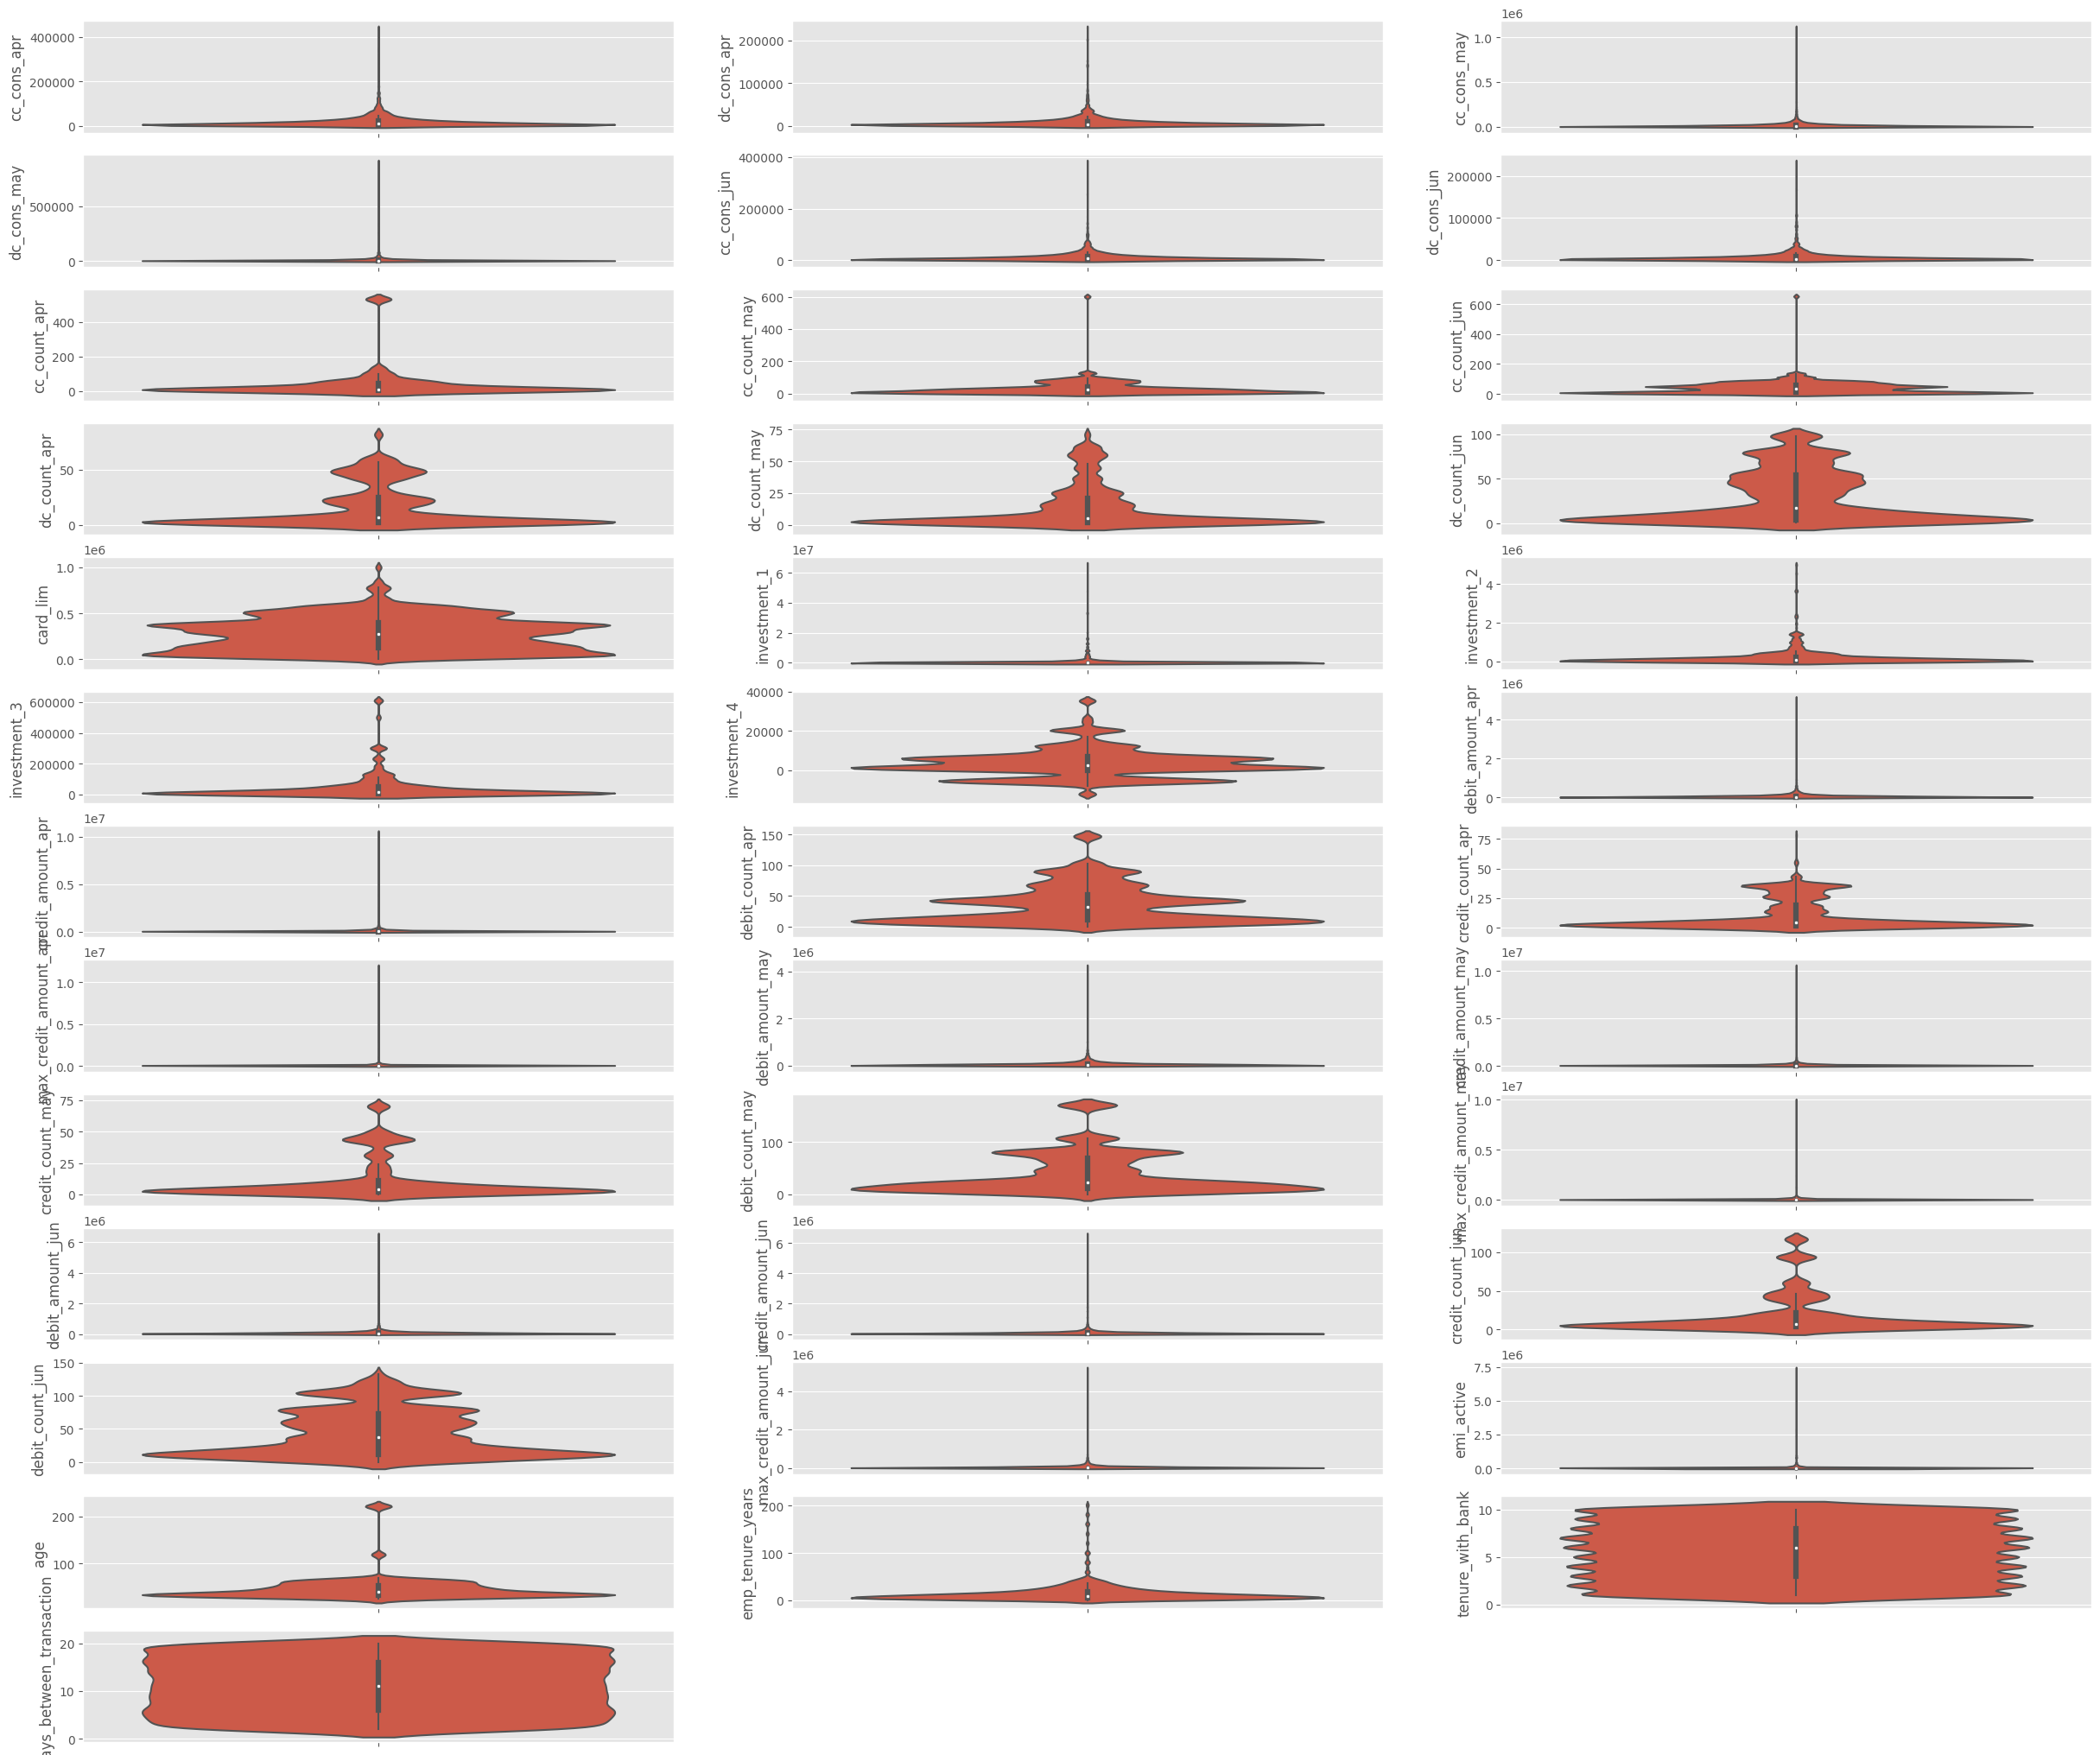

In [17]:
# Create subplots with the specified layout
fig, axes = plt.subplots(20, 3, figsize=(30, 40))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the features and create violin plots
for i, feature in enumerate(numerical_columns):
        sns.violinplot(data=customer_credit, y=feature, ax=axes[i])

# Remove empty subplots
for i in range(len(numerical_columns) - 1, len(axes)):
    fig.delaxes(axes[i])

# Show the plot
plt.show()

In [18]:
# credit and debit consumption columns
cons_features = customer_credit.filter(like='cons_').columns
customer_credit[cons_features].describe(percentiles=(0.25, 0.5, 0.75,0.9, 0.98, 0.99)).T

,count,mean,std,min,25%,50%,75%,90%,98%,99%,max
cc_cons_apr,14995.0,17960.830861,25191.316571,253.00,4411.59,10288.10,21407.625,41017.086,89259.0000,123825.340,441031.33
dc_cons_apr,14995.0,8171.498747,14775.132716,19.35,1634.00,3994.80,9339.020,18439.052,42400.0000,64804.000,229255.00
cc_cons_may,14995.0,16338.688883,27064.983656,157.00,3638.00,8694.00,18951.300,36299.360,85277.5336,126472.214,1117246.31
dc_cons_may,14995.0,7702.797188,18988.978011,22.00,1643.50,3821.00,8212.000,16077.960,44371.4000,64794.240,911223.49
cc_cons_jun,14995.0,12130.345532,18491.403327,65.00,3004.50,6655.25,14247.000,27043.490,64012.7688,86965.225,382914.10
dc_cons_jun,14995.0,7098.205684,13253.768400,62.00,1358.00,3327.00,7597.000,15856.000,41199.0000,71638.000,233384.00


In [19]:
# credit card count features 
customer_credit.filter(like='cc_count').describe(percentiles=(0.25, 0.5, 0.75, 0.95, 0.96, 0.99)).T

,count,mean,std,min,25%,50%,75%,95%,96%,99%,max
cc_count_apr,14995.0,41.492631,97.447505,1.0,5.0,10.0,44.0,124.0,136.0,531.0,531.0
cc_count_may,14995.0,33.488296,49.547493,1.0,8.0,23.0,43.0,93.0,99.0,128.0,601.0
cc_count_jun,14995.0,41.496699,47.347292,1.0,10.0,35.0,61.0,89.0,105.0,135.0,653.0


In [20]:
customer_credit.filter(like='investment').describe(percentiles=(0.25, 0.5, 0.75,0.9, 0.98,0.99)).T

,count,mean,std,min,25%,50%,75%,90%,98%,99%,max
investment_1,14995.0,619606.649025,3.088311e+06,0.3,6100.0,45036.0,161704.0,766011.5,8209320.0,12869465.0,65977430.0
investment_2,14995.0,233390.784792,4.073826e+05,3.0,38173.0,111000.0,245000.0,482147.0,1423567.1,1752254.0,5000000.0
investment_3,14995.0,44393.449143,8.799822e+04,462.0,2214.0,13873.0,48950.0,126001.0,300500.0,610000.0,610000.0
investment_4,14995.0,3523.113863,7.373802e+03,-12179.0,0.0,2351.0,6885.0,12415.0,20790.0,26601.0,35346.0


In [21]:
customer_credit.filter(like='amount').describe(percentiles=(0.25, 0.5, 0.75, 0.9, 0.98, 0.99)).T

,count,mean,std,min,25%,50%,75%,90%,98%,99%,max
debit_amount_apr,14995.0,68222.389109,112682.805998,4.01,23230.430,41875.60,75358.085,139198.326,326885.0800,477906.2920,5156863.79
credit_amount_apr,14995.0,80798.808706,198938.697403,61.38,26846.000,47097.00,85935.000,154070.500,390622.0000,567826.1952,10592125.00
max_credit_amount_apr,14995.0,54397.726617,195126.257418,1.00,20683.000,31914.00,52559.000,96303.000,242348.0000,365000.0000,12029154.00
debit_amount_may,14995.0,65542.073168,101694.374807,28.20,21003.330,38227.78,74400.550,136301.610,324432.6200,446621.9400,4252567.00
credit_amount_may,14995.0,83568.670846,177657.522991,10.61,25398.135,48140.00,94527.680,172569.400,377772.3600,539351.0000,10601749.00
max_credit_amount_may,14995.0,57199.083492,200051.747756,0.25,20083.000,31408.00,55986.000,102500.000,254427.8896,357994.0000,10000000.00
debit_amount_jun,14995.0,76148.384844,154526.451944,5.23,25726.925,45801.49,84438.580,149576.730,328445.4000,518174.9282,6539809.92
credit_amount_jun,14995.0,78506.361142,148219.294951,11.88,24920.080,45901.00,85596.155,157460.200,377141.0000,541767.0300,6611953.00
max_credit_amount_jun,14995.0,52579.597651,128271.287136,0.06,19038.000,30425.00,53206.500,100183.000,255500.0000,378160.0000,5200000.00


In [22]:
customer_credit[['emi_active', 'card_lim']].describe(percentiles=(0.25, 0.5, 0.75,0.9,  0.98, 0.99)).T

,count,mean,std,min,25%,50%,75%,90%,98%,99%,max
emi_active,14995.0,15762.861511,117934.754165,0.0,1549.35,3953.58,9376.39,19804.416,89661.75,157951.88,7447125.13
card_lim,14995.0,277010.284295,179455.280195,0.0,124000.00,272000.00,400000.00,522000.000,650000.00,750000.00,1000000.00


In [23]:
#  list the features for 99th percentile clipping
cols_99th_perc = customer_credit.filter(like='cons_').columns.tolist() + customer_credit.filter(like='amount').columns.tolist()
cols_99th_perc.extend(['cc_count_may', 'cc_count_jun'])

In [24]:
# list the features for 98th percentile clipping 
cols_98th_perc = customer_credit.filter(like='investment').columns.tolist()
cols_98th_perc.extend(['emi_active', 'card_lim'])
# remove 'investment_4'  
cols_98th_perc.remove('investment_4')

In [25]:
customer_credit.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_cons_apr,14995.0,17960.830861,2.519132e+04,253.00,4411.590,10288.10,21407.625,441031.33
dc_cons_apr,14995.0,8171.498747,1.477513e+04,19.35,1634.000,3994.80,9339.020,229255.00
cc_cons_may,14995.0,16338.688883,2.706498e+04,157.00,3638.000,8694.00,18951.300,1117246.31
dc_cons_may,14995.0,7702.797188,1.898898e+04,22.00,1643.500,3821.00,8212.000,911223.49
cc_cons_jun,14995.0,12130.345532,1.849140e+04,65.00,3004.500,6655.25,14247.000,382914.10
dc_cons_jun,14995.0,7098.205684,1.325377e+04,62.00,1358.000,3327.00,7597.000,233384.00
cc_count_apr,14995.0,41.492631,9.744751e+01,1.00,5.000,10.00,44.000,531.00
cc_count_may,14995.0,33.488296,4.954749e+01,1.00,8.000,23.00,43.000,601.00
cc_count_jun,14995.0,41.496699,4.734729e+01,1.00,10.000,35.00,61.000,653.00
dc_count_apr,14995.0,17.167256,1.935888e+01,1.00,2.000,7.00,25.000,82.00


In [26]:
# handle outliers in 'age' and 'emp_tenure_years'.
age_replace = 69
customer_credit['age'] = customer_credit['age'].apply(lambda x: age_replace if x > age_replace else x)

emp_tenure = customer_credit['emp_tenure_years'].quantile(0.95)
customer_credit['emp_tenure_years'] = customer_credit['emp_tenure_years'].apply(lambda x: emp_tenure if x > emp_tenure else x)

### Remove outliers 

Function to remove outliers.

In [27]:
def remove_outliers(dataframe, columns, percentile=0.95):
    """
    Remove outliers from specified columns in a DataFrame.
    
    Parameters:
    - dataframe: The input DataFrame.
    - columns: A list of column names from which outliers should be removed.
    - percentile: The percentile value to determine the threshold for outliers. Default is 0.95.
    
    Returns:
    - DataFrame: A new DataFrame with outliers removed from specified columns.
    """
    
    # Create a copy of the original DataFrame to avoid modifying the input data
    df_copy = dataframe.copy()
    
    # Iterate over the specified columns
    for col in columns:
        # Calculate the threshold for outliers based on the specified percentile
        threshold = df_copy[col].quantile(percentile)
        
        # Remove outliers by replacing them with NaN
        df_copy[col] = np.where(df_copy[col] > threshold, np.nan, df_copy[col])
    
    return df_copy

In [28]:
# clip at 99th percentile
credit_clean_1 = remove_outliers(customer_credit, columns=cols_99th_perc, percentile=0.99)

In [29]:
#  clip at 98th percentile
credit_clean_2 = remove_outliers(credit_clean_1, columns=cols_98th_perc, percentile=0.98)

In [30]:
# clip at 96th percentile
credit_clean_df = remove_outliers(credit_clean_2, columns=['cc_count_apr'], percentile=0.96)

In [31]:
# drop the missing rows.
credit_clean_df.dropna(inplace=True)

In [32]:
# save the outlier treated dataframe
credit_clean_df.to_csv('credit_df_outliers_removed.csv')

### **Train-Test Split**

- We are preparing our data by separating the features (`X_clean`) from the target variable (`Y_clean`). 
- Then, we split the data into two sets: the training set (`X_train` and `y_train`) used to train the model, and the test set (`X_test` and `y_test`) used to evaluate its performance. The test set represents unseen data for assessing the model's generalization. We're allocating 30% of the data to the test set, and random_state=42 ensures reproducibility.

In [33]:
# outlier removed
X_clean = credit_clean_df.drop('cc_cons', axis=1)
Y_clean = credit_clean_df['cc_cons']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.3, random_state=42)

### **Feature Creation**

We derive new features from the existing ones in our dataset. This process allows us to extract additional information or capture unique patterns that might be valuable for our analysis or machine learning models. By engineering new features, we aim to enhance the dataset's richness and provide our models with more informative input variables. This can lead to improved model performance and a deeper understanding of the underlying data.

In [34]:
#  create a list to iterate over for feature creation on both training and validation data
dataframes = [X_train, X_test]

In [35]:
for df in dataframes:
    
    # Transaction Amount Averages
    df['cc_cons_per_count_apr'] = np.where(df['cc_count_apr'] != 0,
                                         df['cc_cons_apr'] / df['cc_count_apr'],
                                          0)

    df['cc_cons_per_count_may'] = np.where(df['cc_count_may'] != 0,
                                         df['cc_cons_may'] / df['cc_count_may'],
                                          0)
    
    df['cc_cons_per_count_jun'] = np.where(df['cc_count_jun'] != 0,
                                         df['cc_cons_jun'] / df['cc_count_jun'],
                                          0)

    df['dc_cons_per_count_apr'] = np.where(df['dc_count_apr'] != 0,
                                         df['dc_cons_apr'] / df['dc_count_apr'],
                                          0)
    
    df['dc_cons_per_count_may'] = np.where(df['dc_count_may'] != 0,
                                         df['dc_cons_may'] / df['dc_count_may'],
                                          0)
    
    df['dc_cons_per_count_jun'] = np.where(df['dc_count_jun'] != 0,
                                         df['dc_cons_jun'] / df['dc_count_jun'],
                                          0)
    
    # credit consumption per credit card transaction 
    df['cc_cons_per_tranxn'] = df[['cc_cons_apr', 'cc_cons_may', 'cc_cons_jun']].sum(axis=1) / \
                               df[['cc_count_apr', 'cc_count_may', 'cc_count_jun']].sum(axis=1)
    
    # debit consumption per transaction 
    df['dc_cons_per_tranxn'] = df[['dc_cons_apr', 'dc_cons_may', 'dc_cons_jun']].sum(axis=1) / \
                               df[['dc_count_apr', 'dc_count_may', 'dc_count_jun']].sum(axis=1)
    
    # Total credit and debit consumption each month 
    df['total_cons_apr'] = df['cc_cons_apr'] + df['dc_cons_apr']
    df['total_cons_may'] = df['cc_cons_may'] + df['dc_cons_may']
    df['total_cons_jun'] = df['cc_cons_jun'] + df['dc_cons_jun']

    # Credit card consumption more than card limit ? 
    df['cc_cons_exceed_lim_apr'] = (df['cc_cons_apr'] > df['card_lim']).astype('int')

    df['cc_cons_exceed_lim_may'] = (df['cc_cons_may'] > df['card_lim']).astype('int')

    df['cc_cons_exceed_lim_jun'] = (df['cc_cons_jun'] > df['card_lim']).astype('int')
    
    # Transaction Amount Averages
    df['avg_credit_transaction_apr'] = np.where(df['credit_count_apr'] != 0,
                                                        df['credit_amount_apr'] / df['credit_count_apr'],
                                                        0)

    df['avg_debit_transaction_apr'] = np.where(df['debit_count_apr'] != 0,
                                                        df['debit_amount_apr'] / df['debit_count_apr'],
                                                        0)

    df['avg_credit_transaction_may'] = np.where(df['credit_count_may'] != 0,
                                                        df['credit_amount_may'] / df['credit_count_may'],
                                                        0)

    df['avg_debit_transaction_may'] = np.where(df['debit_count_may'] != 0,
                                                        df['debit_amount_may'] / df['debit_count_may'],
                                                        0)

    df['avg_credit_transaction_jun'] = np.where(df['credit_count_jun'] != 0,
                                                        df['credit_amount_jun'] / df['credit_count_jun'],
                                                        0)

    df['avg_debit_transaction_jun'] = np.where(df['debit_count_jun'] != 0,
                                                        df['debit_amount_jun'] / df['debit_count_jun'],
                                                        0)
    # Net Monthly Change
    df['net_balance_change_apr'] = df['credit_amount_apr'] - df['debit_amount_apr']
    df['net_balance_change_may'] = df['credit_amount_may'] - df['debit_amount_may']
    df['net_balance_change_jun'] = df['credit_amount_jun'] - df['debit_amount_jun']
    
    # average monthly net change 
    df['avg_net_balance_change'] = df[['net_balance_change_apr', 'net_balance_change_may', 'net_balance_change_jun']].mean(axis=1)
    
    # ratio of total credit card consumption to credit amount for each month 
    df['cc_cons_credit_ratio_apr'] = np.where(df['credit_amount_apr'] != 0,
                                              df['cc_cons_apr'] / df['credit_amount_apr'],
                                              0)

    df['cc_cons_credit_ratio_may'] = np.where(df['credit_amount_may'] != 0,
                                              df['cc_cons_may'] / df['credit_amount_may'],
                                             0)

    df['cc_cons_credit_ratio_jun'] = np.where(df['credit_amount_jun'] != 0,
                                             df['cc_cons_jun'] / df['credit_amount_jun'],
                                             0)

    # Overall Spending Habits
    df['avg_transaction_amount'] = (df['avg_credit_transaction_apr'] +
                                            df['avg_debit_transaction_apr'] +
                                            df['avg_credit_transaction_may'] +
                                            df['avg_debit_transaction_may'] +
                                            df['avg_credit_transaction_jun'] +
                                            df['avg_debit_transaction_jun']) / 6
    # total credit card consumption old
    df['cc_cons_total'] = df[['cc_cons_apr', 'cc_cons_may', 'cc_cons_jun']].sum(axis=1)

    # standard deviation of cc_cons 
    df['cc_cons_std'] = df[['cc_cons_apr', 'cc_cons_may', 'cc_cons_jun']].std(axis=1)
    
    # investment profile
    df['total_investments'] = df[['investment_1', 'investment_2', 'investment_3', 'investment_4']].sum(axis=1)

    # Employment Tenure to Age Ratio
    df['emp_tenure_to_age_ratio'] = df['emp_tenure_years'] / df['age']

    # Tenure with Bank to Age Ratio
    df['tenure_with_bank_to_age_ratio'] = df['tenure_with_bank'] / df['age']

In [36]:
# average credit_card consumption (april to june) by region
# Calculate group means for credit_clean_df
group_means_train = X_train.groupby(['region_code'])['cc_cons_total'].mean()

group_means_test = X_test.groupby(['region_code'])['cc_cons_total'].mean()
# Convert the result to a dictionary
group_means_train_dict = group_means_train.to_dict()

group_means_test_dict = group_means_test.to_dict()

# Map the mean values to create a new feature 'avg_cc_cons_by_region'
X_train['avg_cc_cons_by_region'] = X_train['region_code'].map(group_means_train_dict)

X_test['avg_cc_cons_by_region'] = X_test['region_code'].map(group_means_test_dict)

In [37]:
# Define the age bins and labels
bins = [25, 40, 55, 70]
labels = ['young', 'middle_aged', 'senior']
# Apply age group labels to the DataFrame
X_train['age_group'] = pd.cut(X_train['age'], bins=bins, labels=labels)
# one-hot encoding age groups
X_train = pd.get_dummies(X_train, columns=['age_group'], drop_first=True)

In [38]:
# Define the age bins and labels
bins = [25, 40, 55, 70]
labels = ['young', 'middle_aged', 'senior']
# Apply age group labels to the DataFrame
X_test['age_group'] = pd.cut(X_test['age'], bins=bins, labels=labels)
# one-hot encoding age groups
X_test = pd.get_dummies(X_test, columns=['age_group'], drop_first=True)

In [39]:
# Define the age bins and labels
bins = [100, 400, 600, 1000]
labels = ['region_1', 'region_2', 'region_3']
# Apply age group labels to the DataFrame
X_train['region_division'] = pd.cut(X_train['region_code'], bins=bins, labels=labels)
X_train = pd.get_dummies(X_train, columns=['region_division'], drop_first=True)

In [40]:
# Define the age bins and labels
bins = [100, 400, 600, 1000]
labels = ['region_1', 'region_2', 'region_3']
# Apply age group labels to the DataFrame
X_test['region_division'] = pd.cut(X_test['region_code'], bins=bins, labels=labels)
X_test = pd.get_dummies(X_test, columns=['region_division'], drop_first=True)

In [41]:
# drop region code because it is a nominal categorical variable onee-hot encoding it will increase dimension of the features.
X_train.drop('region_code', axis=1, inplace=True)
X_test.drop('region_code', axis=1, inplace=True)

Drop highly correlated feature:

In [42]:
#function to find highly correlated features 
def correlation(dataset, threshold):
    """
    This function calculates the Pearson correlation coefficient between features in a given dataset
    and identifies pairs of features that have a correlation coefficient greater than the specified threshold.

    Parameters:
    - dataset (DataFrame): The input dataset containing features as columns.
    - threshold : The correlation coefficient threshold to determine which features are highly correlated.

    Returns:
    - col_corr (set): A set containing the names of highly correlated features.
    """
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [43]:
# list the correlated features
corr_features = correlation(X_train, 0.75)
corr_features

{'age_group_senior',
 'cc_cons_std',
 'emp_tenure_to_age_ratio',
 'net_balance_change_apr',
 'net_balance_change_may',
 'tenure_with_bank_to_age_ratio',
 'total_cons_apr',
 'total_cons_jun',
 'total_cons_may',
 'total_investments'}

In [44]:
# drop highly correlated features 
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

_______________________________

### **Feature Scaling**

create a list of numerical features and encoded categorical features. 

In [45]:
categorical_features = ['income','netbanking_flag', 'gender_M', 'account_type_saving','region_division_region_2', 'region_division_region_3',  'age_group_middle_aged']
numerical_features = X_train.drop(categorical_features, axis=1).columns.tolist()

We scale only numerical features and not categorical features. we will use `Robustscaler` since it is less sensitive to outliers in our data. 

In [46]:
# Create a RobustScaler instance
scaler = RobustScaler()

# Scale the numerical features
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit and transform on training data, transform on test data
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Concatenate the scaled numerical features with the categorical features
X_train_scaled = pd.concat([X_train[categorical_features].reset_index(drop=True),X_train_scaled[numerical_features].reset_index(drop=True)], axis=1)
X_test_scaled = pd.concat([X_test[categorical_features].reset_index(drop=True), X_test_scaled[numerical_features].reset_index(drop=True)], axis=1)

## **Feature selection** 

#### **Feature Importance: Decision Trees**

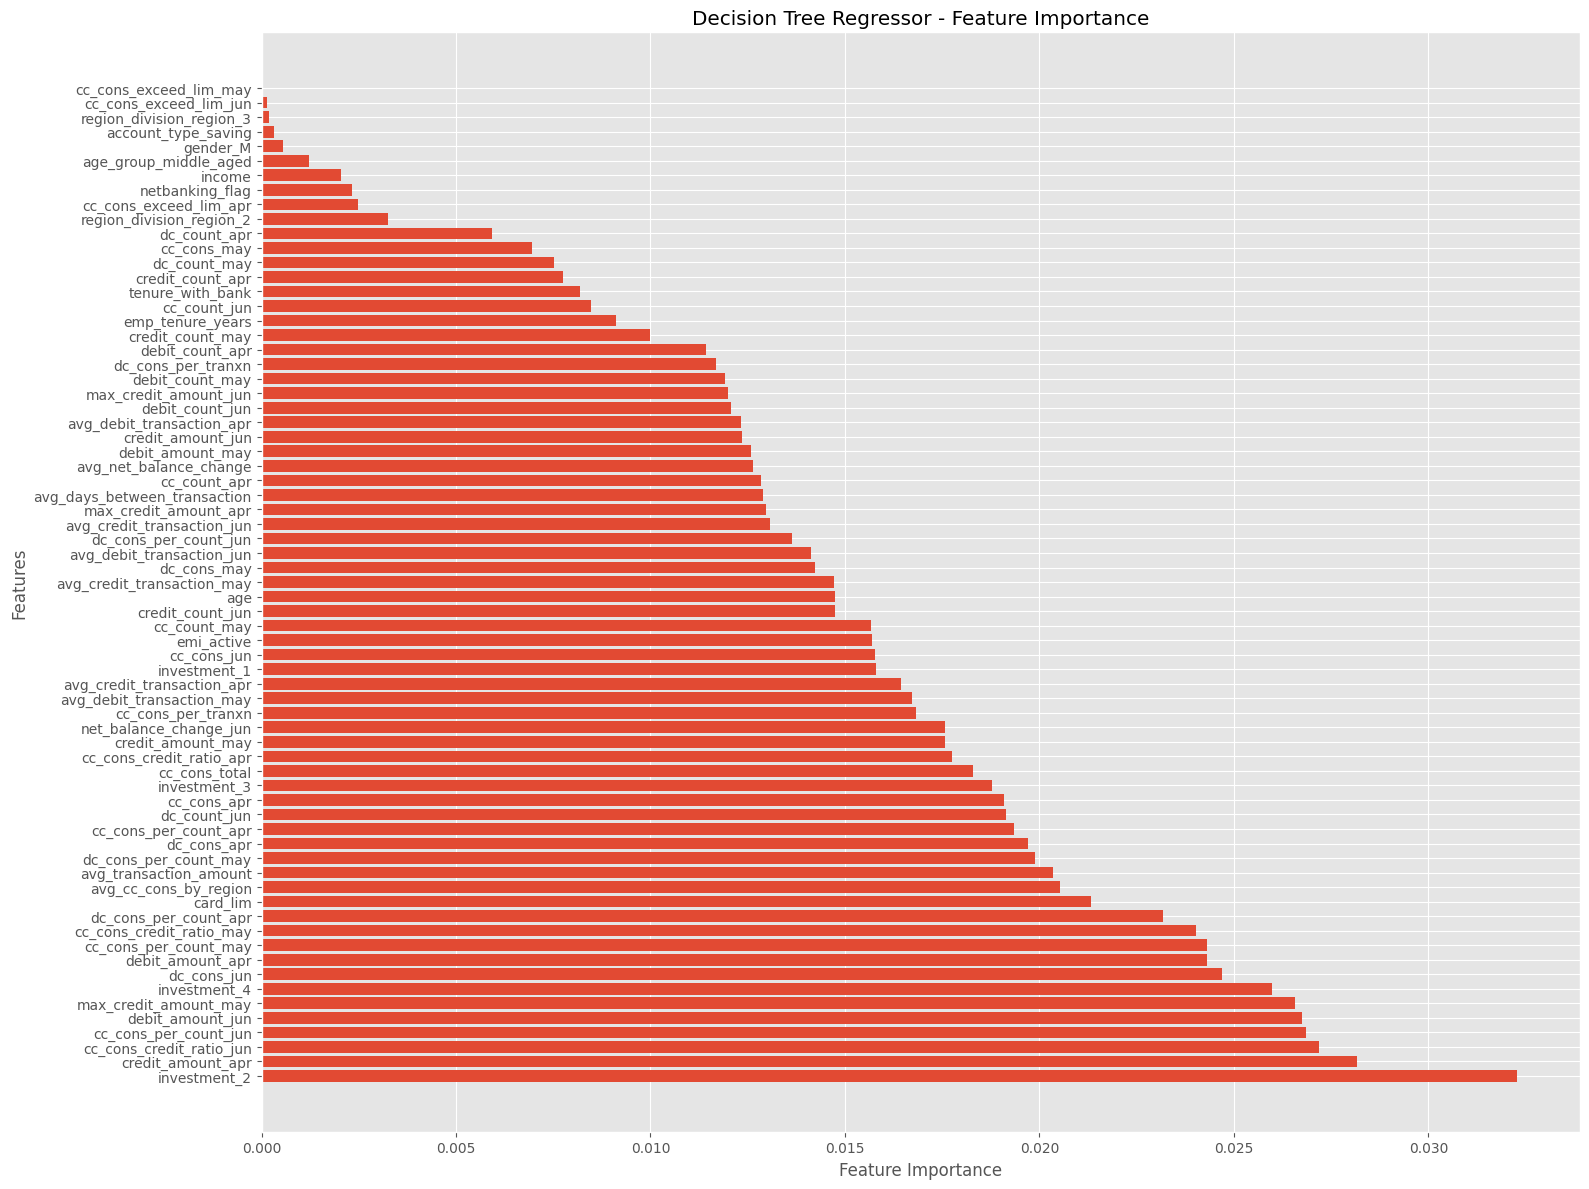

In [47]:
# Create and fit the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
# Get feature importances
feature_importances = dt_model.feature_importances_
# Get top 20 features
top_features_dt = X_train.columns[np.argsort(feature_importances)[::-1]]
# Plot feature importances
plt.figure(figsize=(16, 12))
plt.barh(range(len(feature_importances)), feature_importances[np.argsort(feature_importances)[::-1]], tick_label=top_features_dt)
plt.ylabel("Features")
plt.xlabel("Feature Importance")
plt.title("Decision Tree Regressor - Feature Importance")
plt.tight_layout()
plt.show()

#### **Feature Importance: Random Forest**

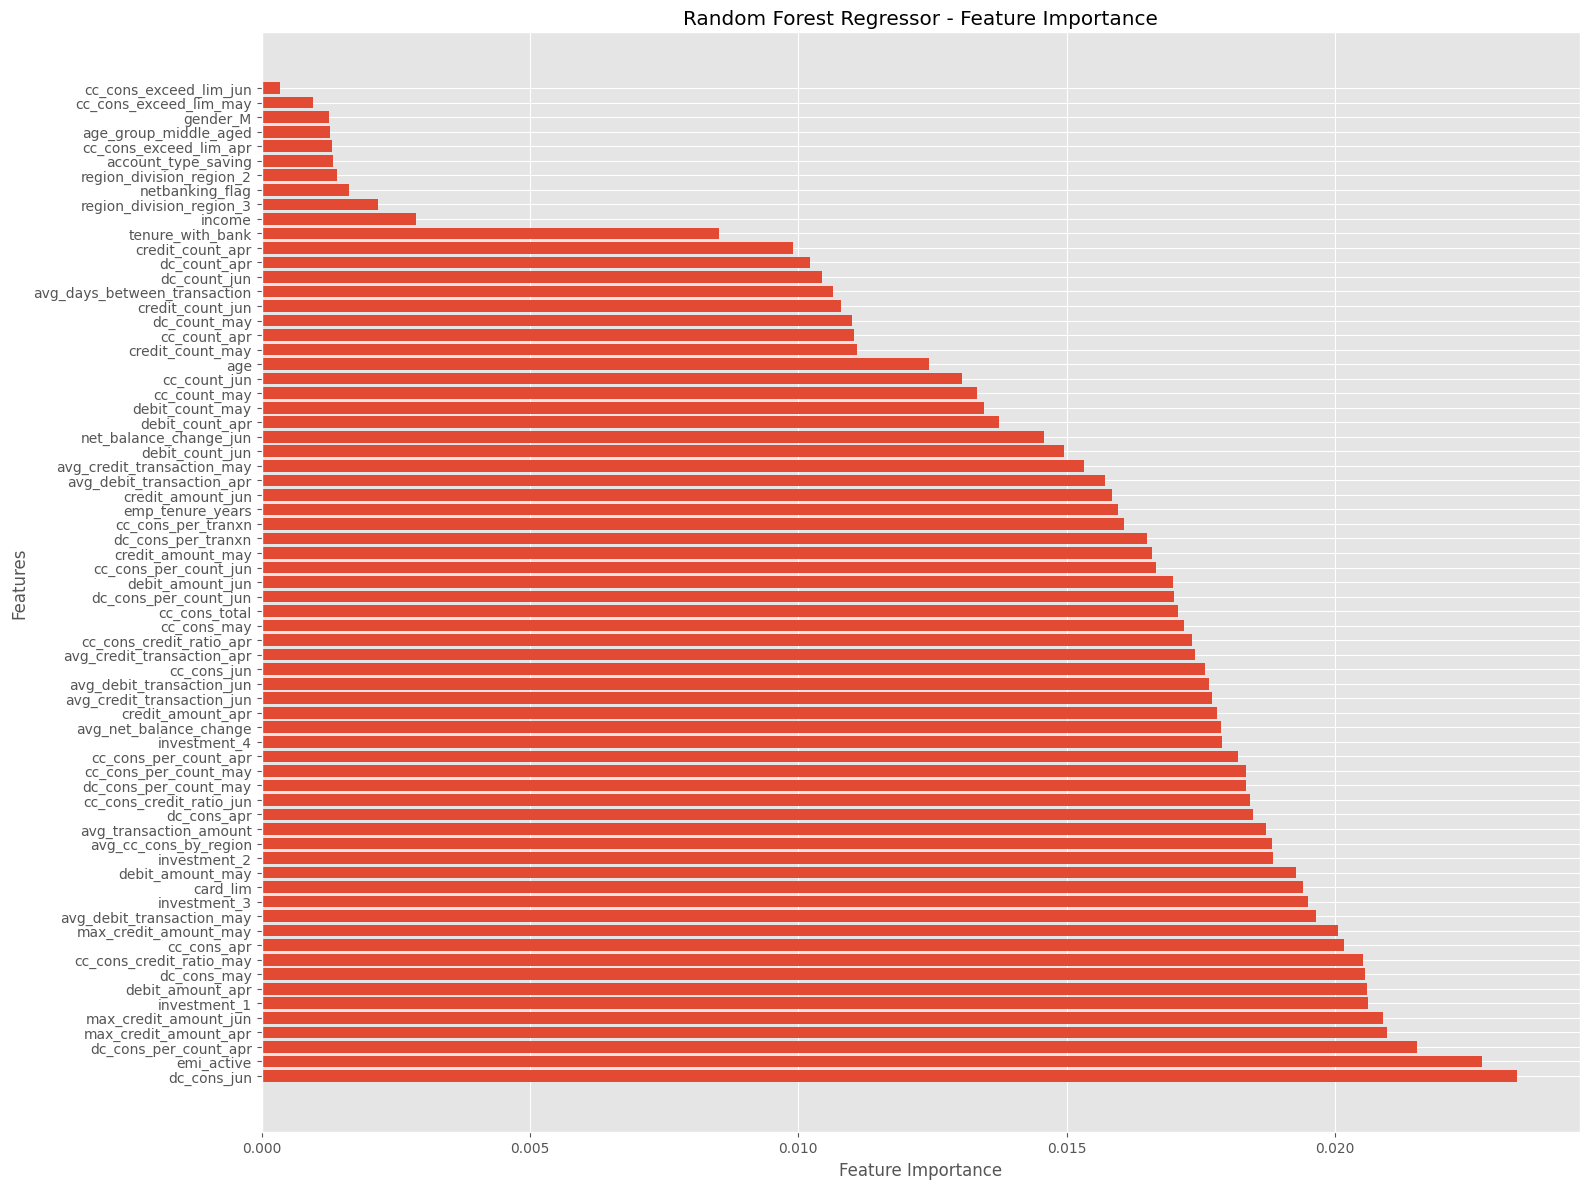

In [48]:
# Create and fit the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances_rf = rf_model.feature_importances_
# Get top 71 features in descending order of importance
top_features_rf = X_train.columns[np.argsort(feature_importances_rf)[::-1]]
# Plot feature importances
plt.figure(figsize=(16, 12))
plt.barh(range(len(feature_importances_rf)), feature_importances_rf[np.argsort(feature_importances_rf)[::-1]], tick_label=top_features_rf)
plt.ylabel("Features")
plt.xlabel("Feature Importance")
plt.title("Random Forest Regressor - Feature Importance")
plt.tight_layout()
plt.show()

#### **Feature Importance: Gradient Boosting**

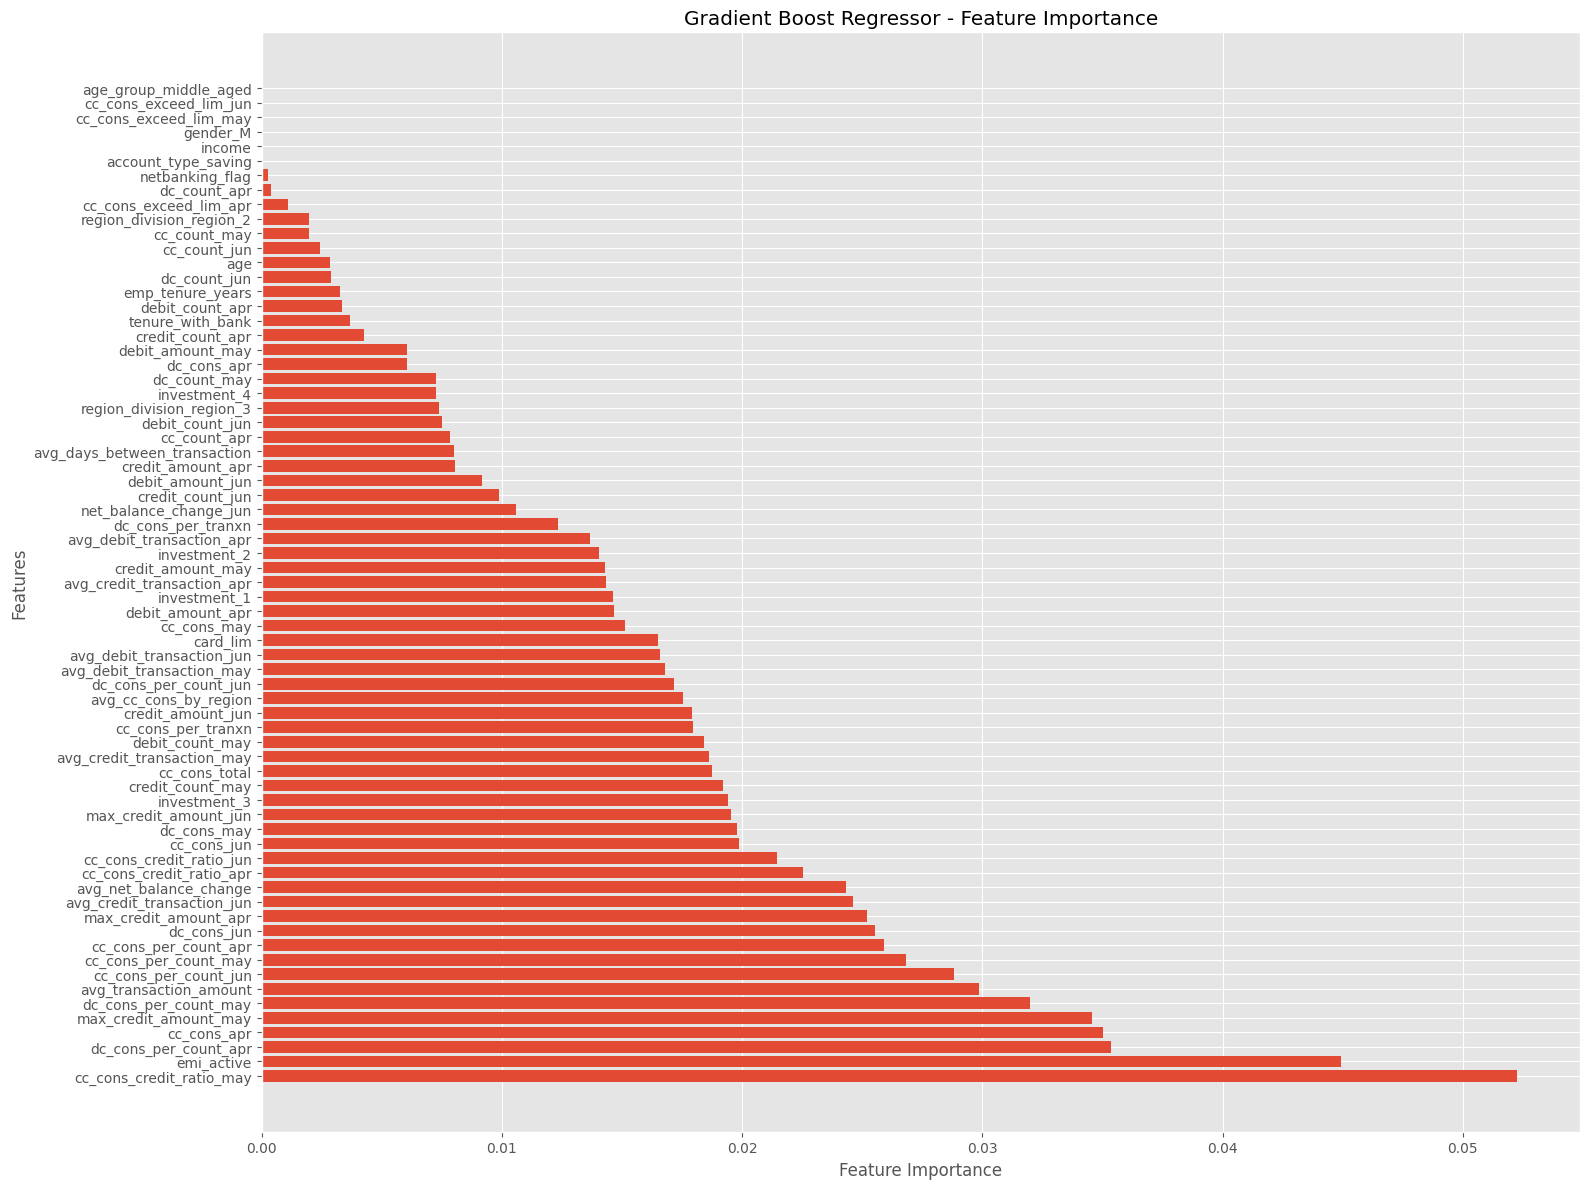

In [49]:
# Create and fit the model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Get feature importances
feature_importances_gb = gb_model.feature_importances_
# Get top 71 features in descending order of importance
top_features_gb = X_train.columns[np.argsort(feature_importances_gb)[::-1]]
# Plot feature importances
plt.figure(figsize=(16, 12))
plt.barh(range(len(feature_importances_gb)), feature_importances_gb[np.argsort(feature_importances_gb)[::-1]], tick_label=top_features_gb)
plt.ylabel("Features")
plt.xlabel("Feature Importance")
plt.title("Gradient Boost Regressor - Feature Importance")
plt.tight_layout()
plt.show()

##### calculate SHAP values for a model trained with the GradientBoostingRegressor algorithm

In [50]:
# Create an explainer object using the SHAP library:
explainer = shap.Explainer(gb_model, X_train)
# Calculate SHAP values for feature set(training)
shap_values = explainer(X_train)

 98%|===================| 7746/7902 [00:15<00:00]        

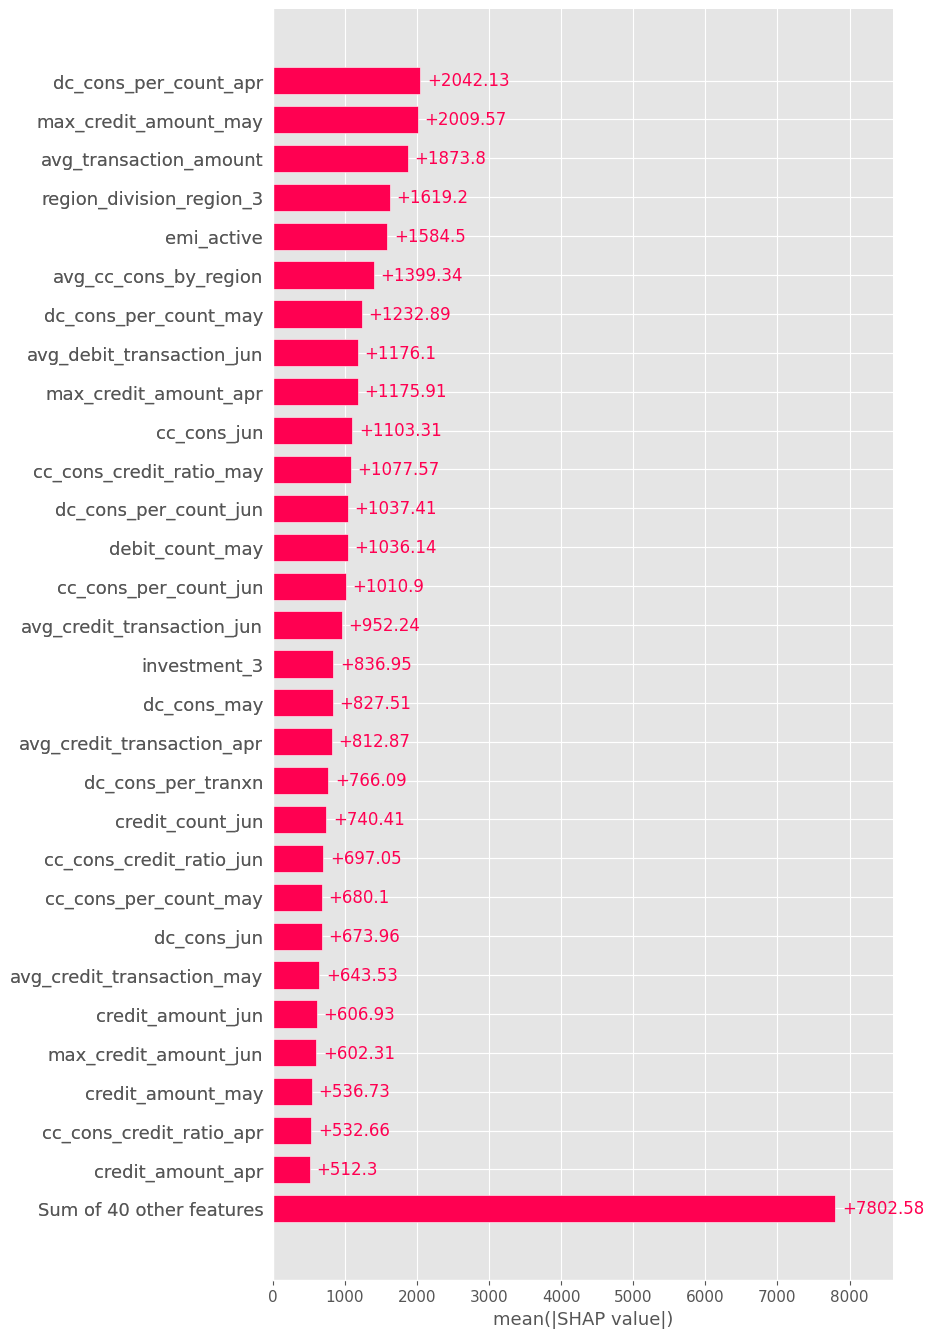

In [51]:
# mean shap plot
shap.plots.bar(shap_values, max_display= 30)

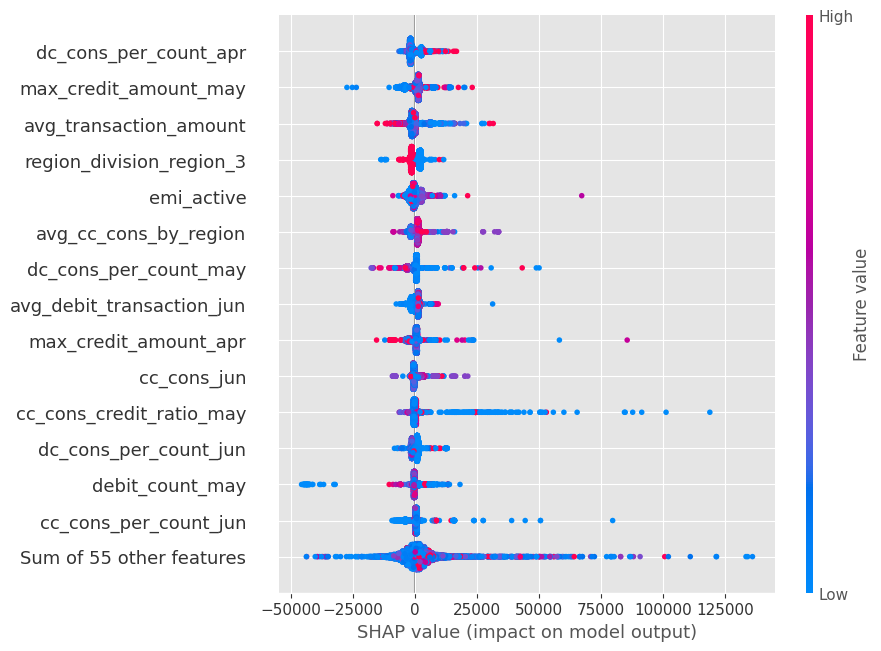

In [52]:
# beeswarm plot
shap.plots.beeswarm(shap_values, max_display=15)

In [53]:
# Calculate mean absolute SHAP values for each feature and associate with feature names
feature_importance = pd.DataFrame(list(zip(X_train.columns, np.abs(shap_values.values).mean(axis=0))), columns=['Feature', 'Importance'])

# Sort features by importance in descending order
features_shap_gb = feature_importance.sort_values(by='Importance', ascending=False)

#### **Feature Importance: XGBoost**

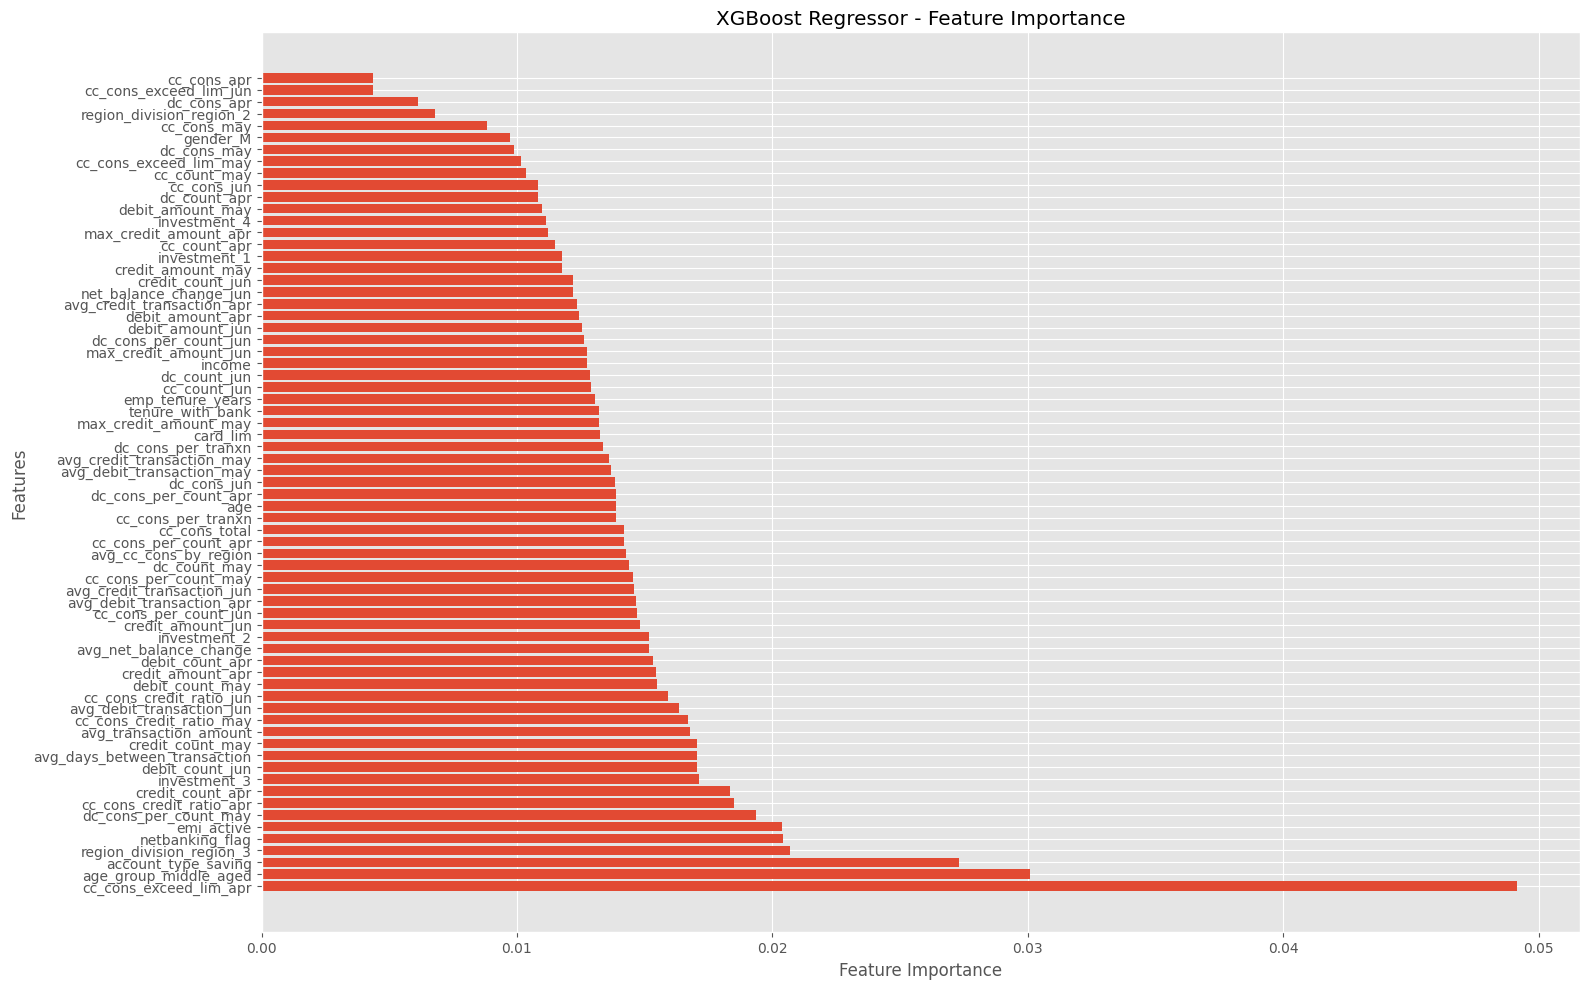

In [54]:
# Create and fit the model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances_xgb = xgb_model.feature_importances_
# Get top 71 features in descending order of importance
top_features_xgb = X_train.columns[np.argsort(feature_importances_xgb)[::-1]]
# Plot feature importances
plt.figure(figsize=(16,10))
plt.barh(range(len(feature_importances_xgb)), feature_importances_xgb[np.argsort(feature_importances_xgb)[::-1]], tick_label=top_features_xgb)
plt.ylabel("Features")
plt.xlabel("Feature Importance")
plt.title("XGBoost Regressor - Feature Importance")
plt.tight_layout()
plt.show()

In [55]:
# Create an explainer object using the SHAP library:
explainer = shap.Explainer(xgb_model, X_train)
# Calculate SHAP values for feature set(training)
shap_values = explainer(X_train)

 99%|===================| 7826/7902 [00:43<00:00]        

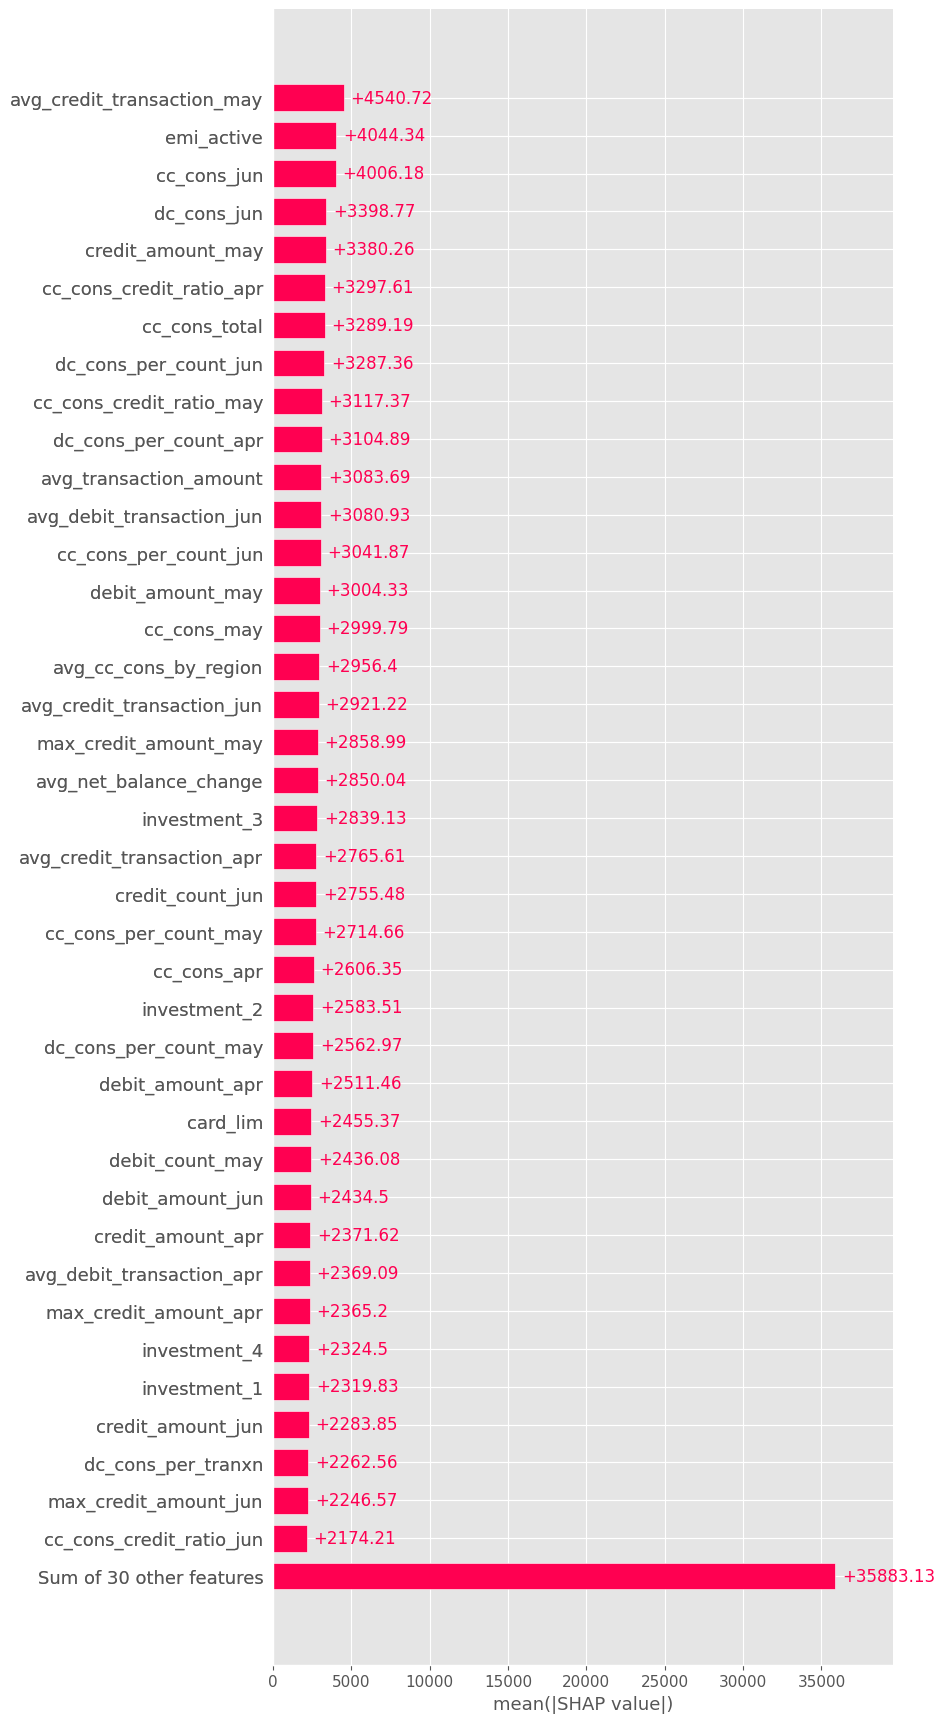

In [56]:
# mean shap plot
shap.plots.bar(shap_values, max_display= 40)

In [57]:
# Calculate mean absolute SHAP values for each feature and associate with feature names
feature_importance = pd.DataFrame(list(zip(X_train.columns, np.abs(shap_values.values).mean(axis=0))), columns=['Feature', 'Importance'])

# Sort features by importance in descending order
features_shap_xgb = feature_importance.sort_values(by='Importance', ascending=False)

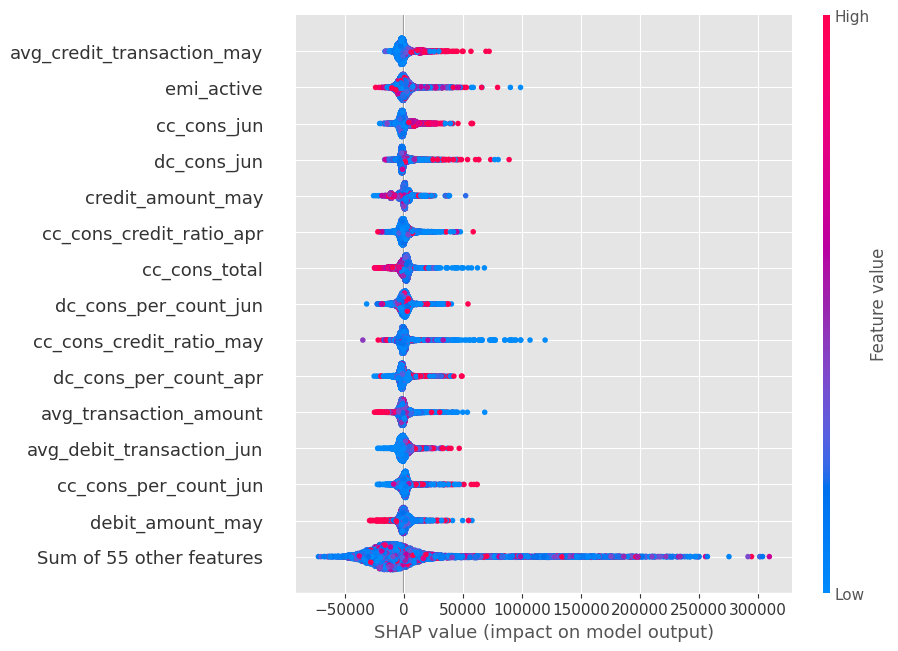

In [58]:
# beeswarm plot
shap.plots.beeswarm(shap_values, max_display=15)

________________________________________

## **Feature Transformation**

### PCA

In [59]:
# Create a PCA instance
pca = PCA()

# Fit PCA on the scaled numerical features
pca.fit(X_train_scaled)

# Calculate explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set a threshold for the desired cumulative explained variance (e.g., 95%)
desired_cumulative_variance = 0.95

# Find the number of components that achieve the desired cumulative explained variance
n_components = np.argmax(cumulative_explained_variance >= desired_cumulative_variance) + 1

print(f"Number of components to achieve {desired_cumulative_variance*100}% cumulative explained variance: {n_components}")

# Create a PCA instance with the desired number of components
pca = PCA(n_components=n_components)

# Fit and transform the PCA on the training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test data using the same PCA
X_test_pca = pca.transform(X_test_scaled)

Number of components to achieve 95.0% cumulative explained variance: 3


__________________

#### Error Metric Function (RMSPE)

In [60]:
def calc_rmspe(y_true, y_pred):
    """
    Calculate Root Mean Square Percentage Error (RMSPE).

    Parameters:
    y_true (array-like): Array of actual target values.
    y_pred (array-like): Array of predicted target values.

    Returns:
    float: RMSPE value.
    """
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate percentage error for each data point, handling division by zero
    percentage_error = np.divide(y_true - y_pred, y_true, out=np.zeros_like(y_true), where=y_true != 0)
    
    # Square the percentage error
    squared_percentage_error = percentage_error ** 2
    
    # Calculate the mean of squared percentage errors
    mean_squared_percentage_error = np.mean(squared_percentage_error)
    
    # Calculate RMSPE by taking the square root of the mean squared percentage error
    rmspe_value = np.sqrt(mean_squared_percentage_error)
    
    return rmspe_value


RMSPE-Scorer

In [61]:
# Define a custom RMSPE scorer with handling for divide by zero
def rmspe_score(y_true, y_pred):
    # Calculate percentage error for each data point, handling division by zero
    percentage_error = np.divide(y_true - y_pred, y_true, out=np.zeros_like(y_true), where=y_true != 0)
    rmspe = np.sqrt(np.mean(percentage_error ** 2))
    return rmspe

rmspe_scorer = make_scorer(rmspe_score, greater_is_better=False)

### **Baseline Error**

In [62]:
# Calculate the mean of the target variable in the training dataset
mean_target = y_train.mean()

# Create an array of predicted values, where all predictions are the mean
baseline_predictions = [mean_target] * len(y_test)

# Calculate the RMSPE for the baseline predictions
baseline_rmspe = calc_rmspe(y_test, baseline_predictions)
# MAE
baseline_mae = mean_absolute_error(y_test, baseline_predictions)
# rmse 
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSPE: {baseline_rmspe: .4f}")
print(f"Baseline MAE: {baseline_mae: .4f}")
print(f"Baseline RMSE: {baseline_rmse: .4f}")

Baseline RMSPE:  117.1561
Baseline MAE:  69812.6196
Baseline RMSE:  97317.3604


### **Model Training** 

Train model using various regression algorithms and calculate error metrics to determine the best model. 

In [63]:
# Create a list of regression models
models = [
    ("Linear Regression", LinearRegression()),
    ("Lasso", Lasso()),  
    ("Ridge", Ridge()),  
    ("KNN", KNeighborsRegressor(n_neighbors=5)), 
]

# Initialize dictionaries to store model performance metrics
train_metrics = {"Model": [], "RMSPE": [], "MAE": [], "RMSE": []}
test_metrics = {"Model": [], "RMSPE": [], "MAE": [], "RMSE": []}

# Iterate through the models
for name, model in models:
    # Fit the model on the training data
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on both train and test data
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    
    # Calculate RMSPE, MAE, and RMSE for train and test data
    train_rmspe = calc_rmspe(y_train, train_pred)
    test_rmspe = calc_rmspe(y_test, test_pred)
    
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    
    # Append model performance metrics to dictionaries
    train_metrics["Model"].append(name)
    train_metrics["RMSPE"].append(train_rmspe)
    train_metrics["MAE"].append(train_mae)
    train_metrics["RMSE"].append(train_rmse)
    
    test_metrics["Model"].append(name)
    test_metrics["RMSPE"].append(test_rmspe)
    test_metrics["MAE"].append(test_mae)
    test_metrics["RMSE"].append(test_rmse)

    # Display model performance for the current model
    print(f"Model: {name}")
    print(f"Train RMSPE: {train_rmspe:.4f}, Test RMSPE: {test_rmspe:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print("=" * 40)

# Display model performance metrics in dataframes for final comparison
train_metrics_df = pd.DataFrame(train_metrics)
test_metrics_df = pd.DataFrame(test_metrics)

Model: Linear Regression
Train RMSPE: 305.3414, Test RMSPE: 133.7161
Train MAE: 69649.2068, Test MAE: 70085.3274
Train RMSE: 97598.5393, Test RMSE: 97910.0323


Model: Lasso
Train RMSPE: 305.3872, Test RMSPE: 133.6987
Train MAE: 69649.6707, Test MAE: 70084.8014
Train RMSE: 97598.5409, Test RMSE: 97908.9481
Model: Ridge
Train RMSPE: 305.3552, Test RMSPE: 133.6895
Train MAE: 69649.3719, Test MAE: 70085.0229
Train RMSE: 97598.5402, Test RMSE: 97909.4777
Model: KNN
Train RMSPE: 371.0320, Test RMSPE: 145.3845
Train MAE: 58399.8172, Test MAE: 71262.8223
Train RMSE: 87944.5682, Test RMSE: 105501.8709


------------------

### K-Nearest Neighbour Regression 

In [239]:
# Create a KNeighborsRegressor 
knn_regressor = KNeighborsRegressor(n_neighbors=11)  

# Fit the model to your training data 
knn_regressor.fit(X_train_pca, y_train)

# Make predictions on the test data 
knn_pred = knn_regressor.predict(X_test_pca)

# calcualte RMSPE
knn_rmspe =calc_rmspe(y_test, knn_pred)
print("KNN Regression RMSPE :", round(knn_rmspe, 4))

KNN Regression RMSPE : 97.8151


Hyperparameter tuning for KNeighbourRegressor

In [69]:
# Create a KNeighborsRegressor
knn_regressor = KNeighborsRegressor()
# Define a dictionary of hyperparameters and their possible values
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
    'p': [1, 2],  # Distance metric (1 for Manhattan, 2 for Euclidean)
    'leaf_size': [5, 10, 15],  # Leaf size for tree optimization
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm for nearest neighbors
    'metric': ['minkowski', 'manhattan', 'euclidean'],  # Metric used for distance calculation
    'n_jobs': [-1]  # Number of CPU cores to use for parallel processing (-1 uses all available cores)
}

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring=make_scorer(rmspe_scorer, greater_is_better=False))
# Fit the grid search to your training data (X_train_scaled and y_train)
grid_search.fit(X_train_pca, y_train)
# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
# Create a new KNeighborsRegressor model with the best hyperparameters
best_knn_regressor = KNeighborsRegressor(**best_params)
# Fit the best model to the training data
best_knn_regressor.fit(X_train_pca, y_train)
# Make predictions on the test data (X_test_scaled)
knn_pred = best_knn_regressor.predict(X_test_pca)
# calcualte RMSPE
knn_rmspe = calc_rmspe(y_test, knn_pred)
print("Best parameters for KNN Regression : ", best_params)
print("KNN Regression (tuned) RMSPE :", round(knn_rmspe, 4))

Best parameters for KNN Regression :  {'algorithm': 'auto', 'leaf_size': 5, 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
KNN Regression (tuned) RMSPE : 113.874


---------------------------

### **Decision Tree Regressor**

In [78]:
# initialize DecisionTreeRegressor
dt_reg= DecisionTreeRegressor(random_state=42)

# fit the model
dt_reg.fit(X_train, y_train)

# predict 
dt_pred = dt_reg.predict(X_test)

# calculate RMSPE
dt_rmspe =  calc_rmspe(y_test, dt_pred)
print("Decision Tree RMSPE:", round(dt_rmspe, 4))

Decision Tree RMSPE: 245.9252


Random Hyperparameters 

In [79]:
# initialize DecisionTreeRegressor
param_grid = {'criterion': 'absolute_error', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
dt_reg= DecisionTreeRegressor(random_state=42, **param_grid)

# fit the model
dt_reg.fit(X_train, y_train)

# predict 
dt_pred = dt_reg.predict(X_test)

# calculate RMSPE
dt_rmspe =  calc_rmspe(y_test, dt_pred)
print("Decision Tree RMSPE:", round(dt_rmspe, 4))

Decision Tree RMSPE: 40.0395


We are using the SHAP (SHapley Additive exPlanations) library to explain the predictions of a machine learning model. SHAP values provide insights into how each feature contributes to individual predictions, helping us understand the importance of each feature in the model's decision-making process.

In [80]:
# Create an explainer object using the SHAP library:
explainer = shap.Explainer(dt_reg, X_train)
# Calculate SHAP values for feature set(training)
shap_values = explainer(X_train)

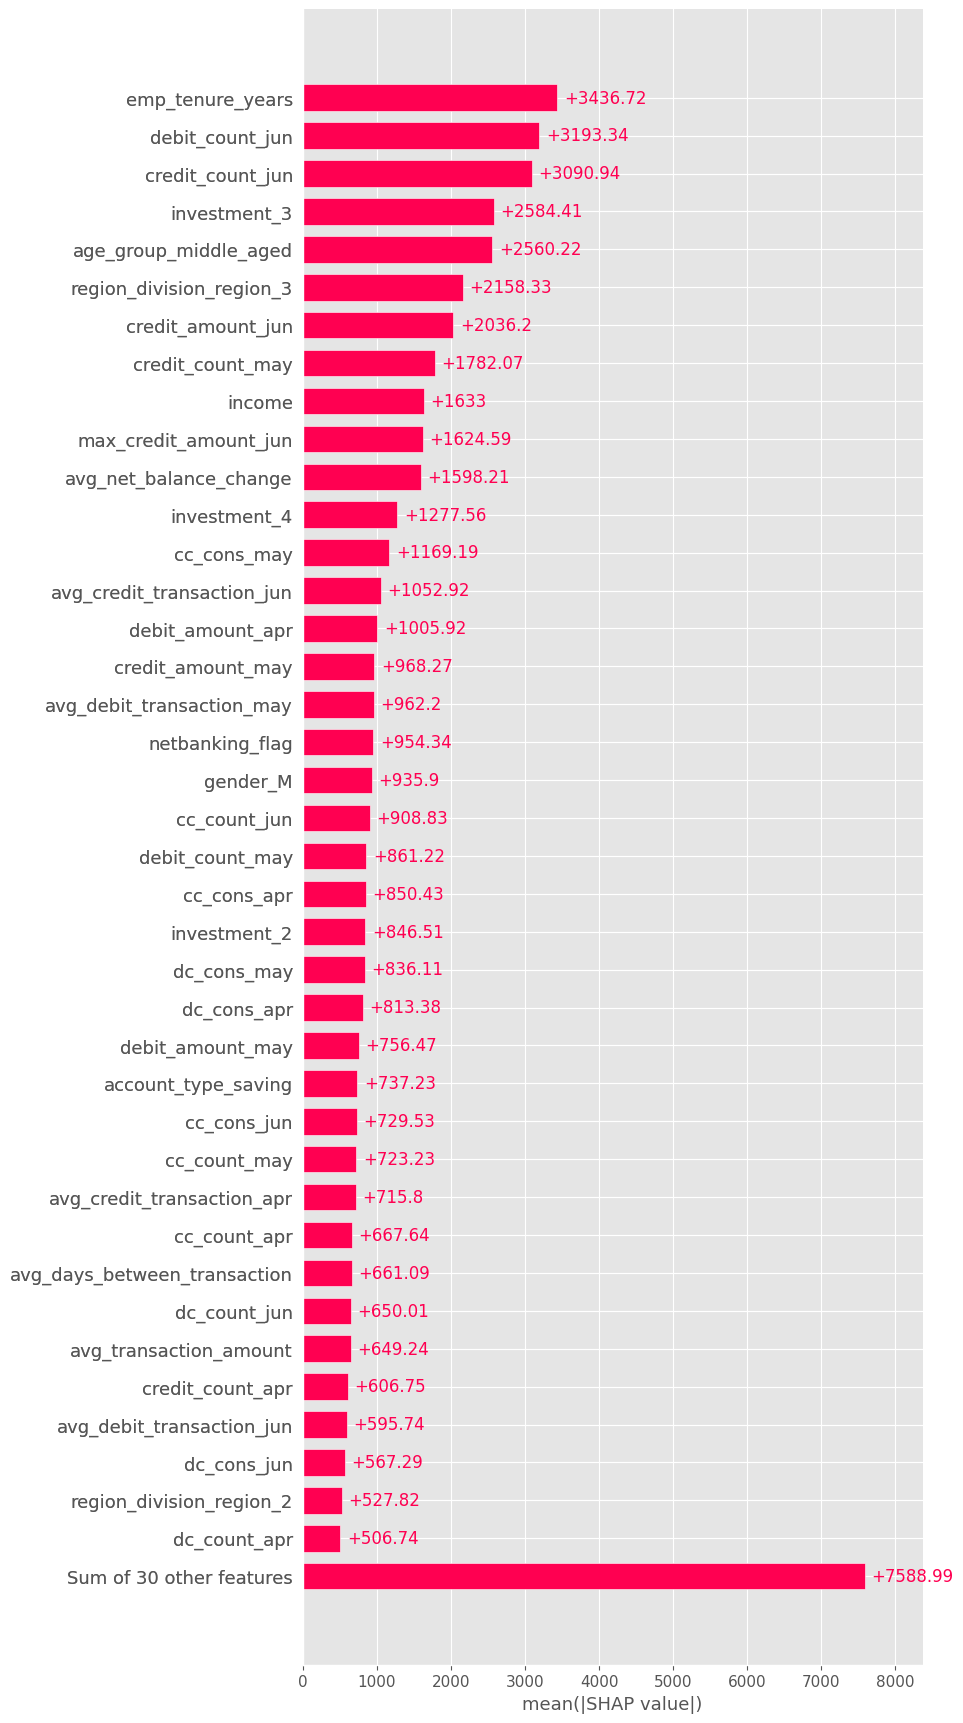

In [83]:
# mean shap plot
shap.plots.bar(shap_values, max_display= 40)

We will select feature based on contribution of features on prediction to prevent overfitting and reduce computational time.

In [84]:
# Calculate mean absolute SHAP values for each feature and associate with feature names
feature_importance = pd.DataFrame(list(zip(X_train.columns, np.abs(shap_values.values).mean(axis=0))), columns=['Feature', 'Importance'])

# Sort features by importance in descending order
features_shap_dt = feature_importance.sort_values(by='Importance', ascending=False)

In [177]:
# select top 20 important features for the model 
top_n_features_dt = features_shap_dt['Feature'][:20]

In [224]:
# initialize DecisionTreeRegressor
param_grid = {
    'criterion': 'absolute_error',
     'max_depth':18, 
     'min_samples_leaf': 3, 
     'min_samples_split': 2, 
     'splitter': 'random', 
     'max_features': 'auto',
     'ccp_alpha':0.1}
dt_reg= DecisionTreeRegressor(random_state=42, **param_grid)

# fit the model
dt_reg.fit(X_train[top_n_features_dt], y_train)

# predict 
dt_pred = dt_reg.predict(X_test[top_n_features_dt])

# calculate RMSPE
dt_rmspe =  calc_rmspe(y_test, dt_pred)
print("Decision Tree RMSPE:", round(dt_rmspe, 4))


Decision Tree RMSPE: 33.7245


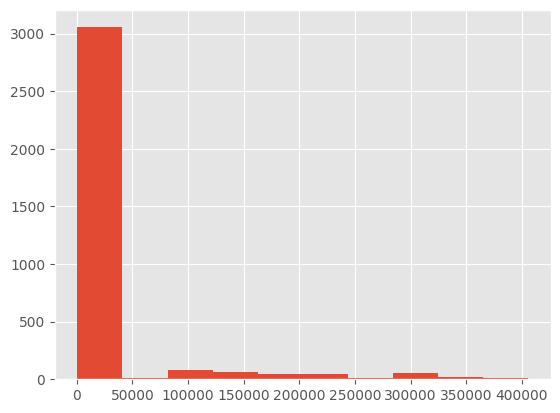

In [168]:
# distribution of predicted values 
plt.hist(dt_pred)
plt.show()

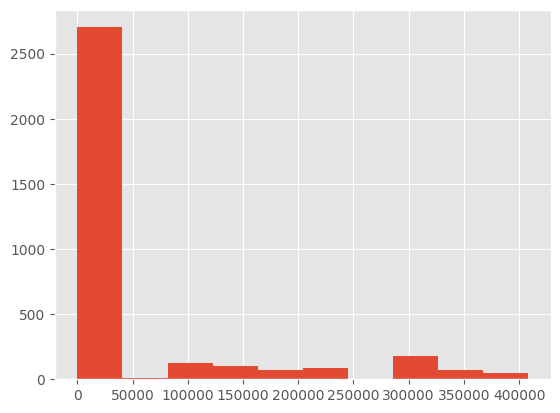

In [169]:
# distribution of actual values 
plt.hist(y_test)
plt.show()

#### Hyper paramter tuning for Decision  Tree regressor 

Hyperparameter tuning for a Decision Tree Regressor using `GridSearch` involves specifying a range of hyperparameter values and then using `GridSearchCV` to search for the best combination of hyperparameters

In [170]:
# Initialize DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Define a dictionary of hyperparameters and their possible values
param_grid = {
    'splitter':['random', 'best'],
    'max_depth': [15, 16, 18, 19],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'criterion': ['absolute_error'],
    'max_features':['auto', 'sqrt'],
    'ccp_alpha':[0.05, 0.1, 0.5]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    dt_reg, param_grid=param_grid, cv=5, scoring=rmspe_scorer, n_jobs=-1, verbose=1
)

# Fit the GridSearchCV to your training data (X_train_scaled, y_train)
grid_search.fit(X_train[top_n_features_dt], y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_

# Create a DecisionTreeRegressor with the best hyperparameters
best_dt_reg = DecisionTreeRegressor(random_state=42, **best_params)

# Fit the best model to the training data
best_dt_reg.fit(X_train[top_n_features_dt], y_train)

# Make predictions on the test data
dt_pred = best_dt_reg.predict(X_test[top_n_features_dt])

# Calculate RMSPE
dt_rmspe = calc_rmspe(y_test, dt_pred)
print('Best parameters for DecisionTree Regression : ', best_params)
print("DecisionTreeRegressor with hyperparameter tuning RMSPE:", round(dt_rmspe, 4))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters for DecisionTree Regression :  {'ccp_alpha': 0.5, 'criterion': 'absolute_error', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
DecisionTreeRegressor with hyperparameter tuning RMSPE: 42.2087


___________________________

### Random Forest Regressor

In [221]:
# let's assume random parameters to have vague idea 
param_dist = {
    'n_estimators':300,
    'max_depth':5,
    'min_samples_leaf':4,
    'min_samples_split':2,
}
rf_reg = RandomForestRegressor(random_state=42, **param_dist)
rf_reg.fit(X_train[top_n_features_dt], y_train)
rf_pred = rf_reg.predict(X_test[top_n_features_dt])
rf_rmspe = calc_rmspe(y_test, rf_pred)
print("RandomForest Regression RMSPE:", round(rf_rmspe, 4))

RandomForest Regression RMSPE: 118.9522


#### Hyperparameter tuning for Random Forest Regression 

In [ ]:
from scipy.stats import randint as sp_randint

# Define a dictionary of hyperparameters and their possible value distributions
param_dist = {
    'n_estimators': sp_randint(100, 401),        # Random integer between 100 and 400
    'max_depth': sp_randint(1, 19),            # Random integer between 15 and 18
    'min_samples_split': sp_randint(2, 4),     # Random integer between 2 and 3
    'min_samples_leaf': sp_randint(2, 5),      # Random integer between 2 and 4   
}

# Create the RandomForestRegressor model
rf_reg = RandomForestRegressor(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf_reg, param_distributions=param_dist, n_iter=50, cv=5, 
    scoring=rmspe_scorer, n_jobs=-1,
    random_state=42, verbose=1
)

# Fit the RandomizedSearchCV to your training data (X_train_scaled, y_train)
random_search.fit(X_train_scaled[top_n_features_dt], y_train)

# Get the best hyperparameters from the search
best_params = random_search.best_params_

# Train the RandomForestRegressor model with the best hyperparameters
best_rf_reg = RandomForestRegressor(random_state=42, **best_params)
best_rf_reg.fit(X_train_scaled[top_n_features_dt], y_train)

# Make predictions and calculate RMSPE
rf_tuned_pred = best_rf_reg.predict(X_test_scaled[top_n_features_dt])
rf_tuned_rmspe_ = calc_rmspe(y_test, rf_tuned_pred)


In [223]:
print("Best Random Forest Regressor Hyperparameters:", best_params)
print("Random Forest Regression RMSPE with Best Hyperparameters:", round(rf_tuned_rmspe_, 4))

Best Random Forest Regressor Hyperparameters: {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 230}
Random Forest Regression RMSPE with Best Hyperparameters: 119.3297


We can see there is no much increase in performance even after hyperparameter tuning. 

_____________________

### Adaptive Boosting 

It works by combining the predictions of multiple weak learners, typically decision trees with limited depth, to create a strong regression model.

Train model on selected features for DecisionTree Regression we are using `dc_reg` with optimal hyper parameters as base_estimator.

In [228]:
# Create an AdaBoostRegressor with the custom base estimator
adaboost_reg = AdaBoostRegressor(base_estimator=dt_reg, 
                                 n_estimators=300, 
                                 learning_rate=0.05, 
                                 random_state=42)

# Fit and use the AdaBoostRegressor as usual
adaboost_reg.fit(X_train[top_n_features_dt], y_train)
adaboost_pred = adaboost_reg.predict(X_test[top_n_features_dt])
adaboost_rmspe = calc_rmspe(y_test, adaboost_pred)
print('RMSPE for Adaptive Boosting model : ', round(adaboost_rmspe, 4))

RMSPE for Gradient Boosting model :  38.2695


_______________________________

### XGBoost Regressor

In [234]:
# Create an XGBoost regressor and fit to training data
xgb_reg= xgb.XGBRegressor(n_estimators=200, max_depth=45, alpha=0.2, gamma=0.2)
xgb_reg.fit(X_train[top_n_features_dt], y_train)
# predict on testing data
xgb_pred = xgb_reg.predict(X_test[top_n_features_dt])
# calculate RMSPE to evaluate model performance
xgb_rmspe = calc_rmspe(y_test, xgb_pred)
print(' XGBoostRegressor RMSPE:', round(xgb_rmspe, 4))

 XGBoostRegressor RMSPE: 162.1132


Hyperparameter tuning 

In [235]:
# Create an XGBoost regressor
xgb_reg = xgb.XGBRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [500, 600, 700],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [5, 15,25],
    'min_child_weight': [0.2, 0.5, 0.7, 0.8],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.2],
    'lambda': [0, 0.1, 0.2]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_grid, n_iter=25, 
                                   scoring=rmspe_scorer,
                                   cv=5, random_state=42, verbose=1)

# Fit the RandomizedSearchCV to your data
random_search.fit(X_train[top_n_features_dt], y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train a new XGBoost regressor with the best hyperparameters
best_xgb_reg = xgb.XGBRegressor(**best_params)
best_xgb_reg.fit(X_train[top_n_features_dt], y_train)

# Predict on the testing data
xgb_tuned_pred = best_xgb_reg.predict(X_test[top_n_features_dt])

# Calculate RMSPE to evaluate model performance
xgb_tuned_rmspe = calc_rmspe(y_test, xgb_tuned_pred)
print('XGBoostRegressor RMSPE with Best Hyperparameters from RandomizedSearchCV:', round(xgb_tuned_rmspe, 4))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
XGBoostRegressor RMSPE with Best Hyperparameters from RandomizedSearchCV: 162.1132


___________________________

Create a dataframe with model name and errormetric to choose model with minimum RMSPE

In [246]:
# create alist of Regression models
model = ['baseline','KNN' , 'Decision Tree' , 'Random Forest', 'Adaptive Boosting', 'XGBoost']
# create a list of model names 
model_name = ['baseline', 'knn_reg', 'dt_reg', 'rf_reg', 'adaboost_reg', 'xgb_reg']
# create a list of error metric(RMSPE)
rmspe_values = [baseline_rmspe, knn_rmspe, dt_rmspe, rf_rmspe, adaboost_rmspe, xgb_rmspe]

# Create a DataFrame using above information 
data = {'Model': model, 'Model Name': model_name, 'Error Metric (RMSPE)': rmspe_values}
model_select_df = pd.DataFrame(data)
print(model_select_df)

               Model    Model Name  Error Metric (RMSPE)
0           baseline      baseline            117.156133
1                KNN       knn_reg             97.815092
2      Decision Tree        dt_reg             33.724458
3      Random Forest        rf_reg            118.952155
4  Adaptive Boosting  adaboost_reg             38.269477
5            XGBoost       xgb_reg            162.113208


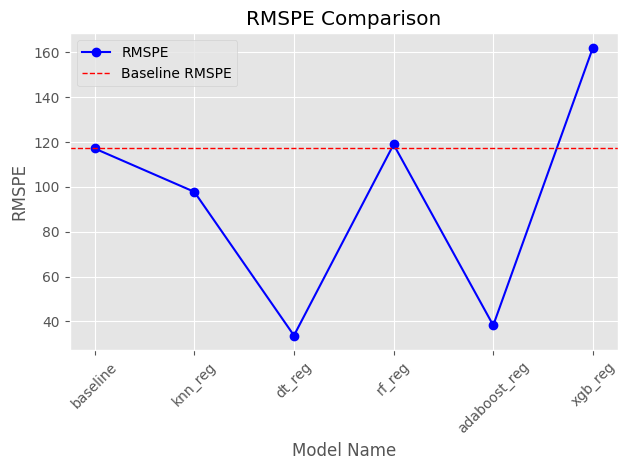

In [245]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot RMSPE values
plt.plot(model_name, rmspe_values, marker='o', linestyle='-', label='RMSPE', color='blue')

# Plot baseline RMSPE as a horizontal red dotted line
plt.axhline(y=baseline_rmspe, color='red', linestyle='--', label='Baseline RMSPE', linewidth=1)

# Set labels and title
plt.xlabel('Model Name')
plt.ylabel('RMSPE')
plt.title('RMSPE Comparison')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

We can see error metric(RMSPE) is minimum for Decision Tree Regressor will choose Decision Tree with tuned hyperparameter for prediction.

In [248]:
# Save the model to a .pkl file
model_filename = 'dt_reg_model.pkl'
joblib.dump(dt_reg, model_filename)

['dt_reg_model.pkl']

________________________

## **Prediction** 

Load the data for prediction 

In [288]:
# read the dataframe to predict the target ('cc_cons')
predict_df = pd.read_csv('predict_target_df.csv')

In [289]:
# read first 5 rows to check 
predict_df.head()

,id,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,account_type,gender,age,income,emp_tenure_years,tenure_with_bank,region_code,netbanking_flag,avg_days_between_transaction,cc_cons
0,17591,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,Y,1170.49,current,M,37,MEDIUM,11.9,4,575.0,1,16.0,NaN
1,13541,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,Y,16447.45,current,M,33,MEDIUM,7.8,6,394.0,0,19.0,NaN
2,13431,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,Y,2622.28,current,M,53,LOW,33.0,10,324.0,1,15.0,NaN
3,8687,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,Y,340.79,current,M,33,MEDIUM,7.8,5,370.0,1,7.0,NaN
4,14727,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,Y,2812.20,current,M,62,LOW,12.6,9,505.0,1,3.0,NaN


In [290]:
# drop target 
predict_df.drop('cc_cons', axis=1, inplace=True)

In [291]:
# check for missing values
predict_df.isnull().sum()

id                              0
cc_cons_apr                     0
dc_cons_apr                     0
cc_cons_may                     1
dc_cons_may                     0
cc_cons_jun                     0
dc_cons_jun                     1
cc_count_apr                    0
cc_count_may                    0
cc_count_jun                    0
dc_count_apr                    0
dc_count_may                    0
dc_count_jun                    0
card_lim                        0
personal_loan_active            0
vehicle_loan_active             0
personal_loan_closed            0
vehicle_loan_closed             0
investment_1                    0
investment_2                    0
investment_3                    0
investment_4                    0
debit_amount_apr                0
credit_amount_apr               0
debit_count_apr                 0
credit_count_apr                0
max_credit_amount_apr           0
debit_amount_may                0
credit_amount_may               0
credit_count_m

In [292]:
# drop missing values 
predict_df.dropna(inplace=True)

In [293]:
# descriptive statistics
predict_df.describe(percentiles=(0.25, 0.5, 0.75, 0.95, 0.99)).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
id,4993.0,9898.491889,5.810788e+03,0.00,4823.00,9824.0000,14928.000,18987.200,1.978524e+04,19999.00
cc_cons_apr,4993.0,17563.880208,2.508699e+04,294.00,4286.86,10028.0000,20660.260,57200.108,1.293170e+05,342847.90
dc_cons_apr,4993.0,8010.740765,1.396017e+04,41.00,1559.00,3879.0000,9354.650,28233.460,6.009500e+04,221348.00
cc_cons_may,4993.0,15720.447724,2.477059e+04,157.00,3619.00,8416.0000,17844.860,51409.568,1.229376e+05,482474.20
dc_cons_may,4993.0,7702.777048,1.411915e+04,22.00,1582.00,3740.0000,8398.000,26607.000,7.047961e+04,332937.94
cc_cons_jun,4993.0,12139.990878,1.965304e+04,75.00,2996.31,6667.0000,14078.975,39661.000,1.002105e+05,302751.41
dc_cons_jun,4993.0,7144.868636,1.350446e+04,62.00,1390.00,3302.0000,7153.000,25932.800,7.916780e+04,233384.00
cc_count_apr,4993.0,41.992790,9.908832e+01,1.00,5.00,10.0000,44.000,124.000,5.310000e+02,531.00
cc_count_may,4993.0,33.819347,5.261016e+01,1.00,8.00,23.0000,43.000,93.000,1.280000e+02,601.00
cc_count_jun,4993.0,41.222311,4.443135e+01,1.00,10.00,35.0000,61.000,89.400,1.350000e+02,653.00


we can remove the features which have standard deviation of 0 becuase they have constant values. 

In [294]:
# list the columns to drop
columns_to_drop = ['personal_loan_active', 'vehicle_loan_active',	'personal_loan_closed', 'vehicle_loan_closed']
# drop the columns 
predict_df.drop(columns=columns_to_drop, axis=1, inplace=True)

## **Feature Engineering**

### Categorical encoding 

In [295]:
predict_df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
loan_enq,4993,1,Y,4993
account_type,4993,2,current,4192
gender,4993,2,M,4336
income,4993,3,MEDIUM,3159


In [296]:
# since we have single class in 'loan_enq' we can drop.
predict_df.drop('loan_enq', axis=1, inplace=True)

- `income` is ordinal categorical variable we perform ordinal encoding
- `gender` and `account_type` type are nominal variables we perform one-hot encoding

In [297]:
# ordiinal mapping
ordinal_mapping = {'HIGH': 2, 'MEDIUM': 1, 'LOW':0}
# label encoding the ordinal variable
predict_df['income'] = predict_df['income'].map(ordinal_mapping)
# one-hot encoding nominal categorical variables : gender and account_type
predict_df = pd.get_dummies(predict_df, columns=['gender', 'account_type'], drop_first=True) 

________________________

## **Outlier Treatment**

In [315]:
#  list the features for 99th percentile clipping
cols_99th_perc = predict_df.filter(like='cons_').columns.tolist() + predict_df.filter(like='amount').columns.tolist()
cols_99th_perc.extend(['cc_count_may', 'cc_count_jun'])

In [316]:
# list the features for 98th percentile clipping 
cols_98th_perc = predict_df.filter(like='investment').columns.tolist()
cols_98th_perc.extend(['emi_active', 'card_lim'])
# remove 'investment_4'  
cols_98th_perc.remove('investment_4')

In [317]:
# handle outliers in 'age' and 'emp_tenure_years'.
age_replace = 69
predict_df['age'] = predict_df['age'].apply(lambda x: age_replace if x > age_replace else x)

emp_tenure = predict_df['emp_tenure_years'].quantile(0.95)
predict_df['emp_tenure_years'] = predict_df['emp_tenure_years'].apply(lambda x: emp_tenure if x > emp_tenure else x)

In [318]:
# clip at 99th percentile
predict_clean_1 = remove_outliers(predict_df, columns=cols_99th_perc, percentile=0.99)

In [302]:
#  clip at 98th percentile
predict_clean_2 = remove_outliers(predict_clean_1, columns=cols_98th_perc, percentile=0.98)

In [319]:
# clip at 96th percentile
predict_clean_df = remove_outliers(predict_clean_2, columns=['cc_count_apr'], percentile=0.96)

In [320]:
# drop the missing values
predict_clean_df.dropna(inplace=True)

### **Feature Creation**

In [321]:
# Transaction Amount Averages
predict_clean_df['cc_cons_per_count_apr'] = np.where(predict_clean_df['cc_count_apr'] != 0,
                                         predict_clean_df['cc_cons_apr'] / predict_clean_df['cc_count_apr'],
                                          0)

predict_clean_df['cc_cons_per_count_may'] = np.where(predict_clean_df['cc_count_may'] != 0,
                                         predict_clean_df['cc_cons_may'] / predict_clean_df['cc_count_may'],
                                          0)
    
predict_clean_df['cc_cons_per_count_jun'] = np.where(predict_clean_df['cc_count_jun'] != 0,
                                         predict_clean_df['cc_cons_jun'] / predict_clean_df['cc_count_jun'],
                                          0)

predict_clean_df['dc_cons_per_count_apr'] = np.where(predict_clean_df['dc_count_apr'] != 0,
                                         predict_clean_df['dc_cons_apr'] / predict_clean_df['dc_count_apr'],
                                          0)
    
predict_clean_df['dc_cons_per_count_may'] = np.where(predict_clean_df['dc_count_may'] != 0,
                                         predict_clean_df['dc_cons_may'] / predict_clean_df['dc_count_may'],
                                          0)
    
predict_clean_df['dc_cons_per_count_jun'] = np.where(predict_clean_df['dc_count_jun'] != 0,
                                         predict_clean_df['dc_cons_jun'] / predict_clean_df['dc_count_jun'],
                                          0)
    
# credit consumption per credit card transaction 
predict_clean_df['cc_cons_per_tranxn'] = predict_clean_df[['cc_cons_apr', 'cc_cons_may', 'cc_cons_jun']].sum(axis=1) / \
                               predict_clean_df[['cc_count_apr', 'cc_count_may', 'cc_count_jun']].sum(axis=1)
    
# debit consumption per transaction 
predict_clean_df['dc_cons_per_tranxn'] = predict_clean_df[['dc_cons_apr', 'dc_cons_may', 'dc_cons_jun']].sum(axis=1) / \
                               predict_clean_df[['dc_count_apr', 'dc_count_may', 'dc_count_jun']].sum(axis=1)
    
# Total credit and debit consumption each month 
predict_clean_df['total_cons_apr'] = predict_clean_df['cc_cons_apr'] + predict_clean_df['dc_cons_apr']
predict_clean_df['total_cons_may'] = predict_clean_df['cc_cons_may'] + predict_clean_df['dc_cons_may']
predict_clean_df['total_cons_jun'] = predict_clean_df['cc_cons_jun'] + predict_clean_df['dc_cons_jun']

# Credit card consumption more than card limit ? 
predict_clean_df['cc_cons_exceed_lim_apr'] = (predict_clean_df['cc_cons_apr'] > predict_clean_df['card_lim']).astype('int')

predict_clean_df['cc_cons_exceed_lim_may'] = (predict_clean_df['cc_cons_may'] > predict_clean_df['card_lim']).astype('int')

predict_clean_df['cc_cons_exceed_lim_jun'] = (predict_clean_df['cc_cons_jun'] > predict_clean_df['card_lim']).astype('int')
    
# Transaction Amount Averages
predict_clean_df['avg_credit_transaction_apr'] = np.where(predict_clean_df['credit_count_apr'] != 0,
                                                        predict_clean_df['credit_amount_apr'] / predict_clean_df['credit_count_apr'],
                                                        0)

predict_clean_df['avg_debit_transaction_apr'] = np.where(predict_clean_df['debit_count_apr'] != 0,
                                                        predict_clean_df['debit_amount_apr'] / predict_clean_df['debit_count_apr'],
                                                        0)

predict_clean_df['avg_credit_transaction_may'] = np.where(predict_clean_df['credit_count_may'] != 0,
                                                        predict_clean_df['credit_amount_may'] / predict_clean_df['credit_count_may'],
                                                        0)

predict_clean_df['avg_debit_transaction_may'] = np.where(predict_clean_df['debit_count_may'] != 0,
                                                        predict_clean_df['debit_amount_may'] / predict_clean_df['debit_count_may'],
                                                        0)

predict_clean_df['avg_credit_transaction_jun'] = np.where(predict_clean_df['credit_count_jun'] != 0,
                                                        predict_clean_df['credit_amount_jun'] / predict_clean_df['credit_count_jun'],
                                                        0)

predict_clean_df['avg_debit_transaction_jun'] = np.where(predict_clean_df['debit_count_jun'] != 0,
                                                        predict_clean_df['debit_amount_jun'] / predict_clean_df['debit_count_jun'],
                                                        0)
# Net Monthly Change
predict_clean_df['net_balance_change_apr'] = predict_clean_df['credit_amount_apr'] - predict_clean_df['debit_amount_apr']
predict_clean_df['net_balance_change_may'] = predict_clean_df['credit_amount_may'] - predict_clean_df['debit_amount_may']
predict_clean_df['net_balance_change_jun'] = predict_clean_df['credit_amount_jun'] - predict_clean_df['debit_amount_jun']

# average monthly net change 
predict_clean_df['avg_net_balance_change'] = predict_clean_df[['net_balance_change_apr', 'net_balance_change_may', 'net_balance_change_jun']].mean(axis=1)

# ratio of total credit card consumption to credit amount for each month 
predict_clean_df['cc_cons_credit_ratio_apr'] = np.where(predict_clean_df['credit_amount_apr'] != 0,
                                              predict_clean_df['cc_cons_apr'] / predict_clean_df['credit_amount_apr'],
                                              0)

predict_clean_df['cc_cons_credit_ratio_may'] = np.where(predict_clean_df['credit_amount_may'] != 0,
                                              predict_clean_df['cc_cons_may'] / predict_clean_df['credit_amount_may'],
                                             0)

predict_clean_df['cc_cons_credit_ratio_jun'] = np.where(predict_clean_df['credit_amount_jun'] != 0,
                                             predict_clean_df['cc_cons_jun'] / predict_clean_df['credit_amount_jun'],
                                             0)

# Overall Spending Habits
predict_clean_df['avg_transaction_amount'] = (predict_clean_df['avg_credit_transaction_apr'] +
                                            predict_clean_df['avg_debit_transaction_apr'] +
                                            predict_clean_df['avg_credit_transaction_may'] +
                                            predict_clean_df['avg_debit_transaction_may'] +
                                            predict_clean_df['avg_credit_transaction_jun'] +
                                            predict_clean_df['avg_debit_transaction_jun']) / 6

# total credit card consumption old
predict_clean_df['cc_cons_total'] = predict_clean_df[['cc_cons_apr', 'cc_cons_may', 'cc_cons_jun']].sum(axis=1)

# standard deviation of cc_cons 
predict_clean_df['cc_cons_std'] = predict_clean_df[['cc_cons_apr', 'cc_cons_may', 'cc_cons_jun']].std(axis=1)

# investment profile
predict_clean_df['total_investments'] = predict_clean_df[['investment_1', 'investment_2', 'investment_3', 'investment_4']].sum(axis=1)

# Employment Tenure to Age Ratio
predict_clean_df['emp_tenure_to_age_ratio'] = predict_clean_df['emp_tenure_years'] / predict_clean_df['age']

# Tenure with Bank to Age Ratio
predict_clean_df['tenure_with_bank_to_age_ratio'] = predict_clean_df['tenure_with_bank'] / predict_clean_df['age']


In [322]:
# average credit_card consumption (april to june) by region
# Calculate group means for credit_clean_df
group_means =predict_clean_df.groupby(['region_code'])['cc_cons_total'].mean()

# Convert the result to a dictionary
group_means_dict = group_means.to_dict()

# Map the mean values to create a new feature 'avg_cc_cons_by_region'
predict_clean_df['avg_cc_cons_by_region'] = predict_clean_df['region_code'].map(group_means)

In [323]:
# Define the age bins and labels
bins = [25, 40, 55, 70]
labels = ['young', 'middle_aged', 'senior']
# Apply age group labels to the DataFrame
predict_clean_df['age_group'] = pd.cut(predict_clean_df['age'], bins=bins, labels=labels)
# one-hot encoding age groups
predict_clean_df = pd.get_dummies(predict_clean_df, columns=['age_group'], drop_first=True)

In [324]:
# Define the age bins and labels
bins = [100, 400, 600, 1000]
labels = ['region_1', 'region_2', 'region_3']
# Apply age group labels to the DataFrame
predict_clean_df['region_division'] = pd.cut(predict_clean_df['region_code'], bins=bins, labels=labels)
predict_clean_df = pd.get_dummies(predict_clean_df, columns=['region_division'], drop_first=True)

### Feature selection

In [325]:
# select best features for decision tree model during model training 
selected_features = top_n_features_dt

### Prediction of Target (`cc_cons`)

In [326]:
predict = dt_reg.predict(predict_clean_df[selected_features])

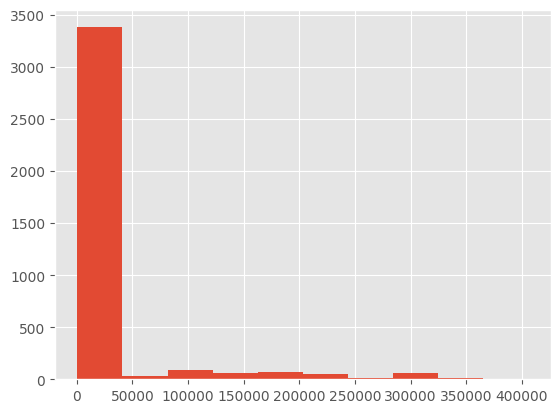

In [327]:
# distribution of predicted values
plt.hist(predict)
plt.show()

In [329]:
# select relevant information 'id', 'age', 'region_code' and 'prediction to save as a result. 
result_df = predict_clean_df[['id', 'age', 'region_code']]
result_df['cc_cons'] = predict

In [331]:
# region_code as integer from float for better representation.
result_df['region_code'] = result_df['region_code'].astype('int')

In [332]:
result_df.head()

,id,age,region_code,cc_cons
0,17591,37,575,11516.0
1,13541,33,394,12609.5
2,13431,53,324,10303.0
3,8687,33,370,14661.0
5,14988,30,454,14107.5


In [333]:
# save the result as .csv
result_df.to_csv('result.csv', index=False)